# Проект: Предсказание температуры стали на металлургическом комбинате.

## Цель проекта.

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

В качестве метрики применять `MAE`. Получить значение MAE для лучшей модели на тестовой выборке не более `6.8`.

### Описание этапа обработки.

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной
температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).


### Описание данных.

Данные состоят из файлов, полученных из разных источников:
* `data_arc_new.csv` — данные об электродах;
* `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
* `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);
* `data_gas_new.csv` — данные о продувке сплава газом;
* `data_temp_new.csv` — результаты измерения температуры;
* `data_wire_new.csv` — данные о проволочных материалах (объём);
* `data_wire_time_new.csv` — данные о проволочных материалах (время).  

Данные также находятся в тренажёре, в папке `/datasets/`.

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.



### План работы.

1. Загрузка и исследование данных.
* Корректная загрузка всех семи датафреймов.
* Поиск аномальных значений.
* Определение пропусков.
* Определение дубликатов.
* Проверка нормальности распределения по гистограммам распределения и графику 'фщик с усами'.


2. Предобработка данных.
* Удаление аномалий.
* Заполнение пропусков.
* Создание новых признаков.
* Агрегирование по ключу.
* Определение дополнительных признаков.
* Определдение целевого признака.

3. Разработка моделей.
* Создание объединённого датафрейма.
* Проверка на мультиколлинеарность.
* Предобработка датафрейма с учётом планируемых к использоанию моделей.
* Проведение масштабирования.
* Разделение на выборки train и test.
* Создание и обучение не менее 3 моделей.
* Подбор гиперпараметров c GridSearchCV.
* Получение метрики MAE на кросс-валидации.
* Выбор лучшей модели.
* Проверка качества лучшей модели на тестовой выборке.
* Исследование важности признаков.

4. Итоговые выводы.

## Загрузка и исследование данных.

In [1]:
#!pip install skimpy

In [2]:
#!pip install imblearn

In [3]:
# Все import соберем в начале проекта:

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import re
import time
import seaborn as sns
import xgboost as xgb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from skimpy import skim, clean_columns


from tqdm.auto import tqdm
from sklearn.dummy import DummyRegressor
from scipy.stats import uniform, loguniform
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split, GridSearchCV, 
                                    RandomizedSearchCV, KFold, cross_val_score)
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler, MinMaxScaler,
                                   PolynomialFeatures)
from imblearn.pipeline import make_pipeline as make_imblearn_pipeline


# Введем глобальную переменные:
RANDOM_STATE_FIX = 300623
TEST_SIZE_FIX = 0.25

# Настроим вид таблиц:
pd.set_option("display.max_rows", 25)
pd.set_option("display.max_columns", 50)
# Ограничим ширину отображающихся столбцов
pd.options.display.max_colwidth = 50
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)
# Настроим, чтобы числа в датасетах отражались с 3 знаками после запятой
pd.set_option('display.float_format', '{:.3f}'.format) 

### Загрузим данные.

Так как файлов с данными несколько, то:
1) Заведем имена файлов с датафпеймами в список.
2) Будем читать файлы и на локальном компьютере, и на удаленном сервере согласно заведенного списка.
3) Создадим словарь и по ключу словаря будем обращаться к нужному датасету.

Кроме того:
* Отмечаем, что во всех файлах значения отделены запятыми.  
* Обращаем внимание на то, что во всех файлах первым признаком идёт `key`. Его и переведём в индексы.  

In [4]:
files = ['data_arc_new.csv', 
         'data_bulk_new.csv',
         'data_bulk_time_new.csv',
         'data_gas_new.csv',
         'data_temp_new.csv',
         'data_wire_new.csv',
         'data_wire_time_new.csv'
        ]

local_path = 'datasets/'  
remote_path = 'https://code.s3.yandex.net/datasets/'

df = {}
for file in files:
    if os.path.exists(local_path + file):
        df[file[:-4]] = pd.read_csv(local_path+file, index_col=[0], sep=',')
        print('Local dataset "' + file + '" is loaded successfully.')
    elif os.path.exists(remote_path + file):
        df[file[:-4]] = pd.read_csv(remote_path+file, index_col=[0], sep=',')
        print('Remote dataset "' + file + '" is loaded successfully.')
    else:
        print('Something is wrong with "' + file + '" !!!')

Local dataset "data_arc_new.csv" is loaded successfully.
Local dataset "data_bulk_new.csv" is loaded successfully.
Local dataset "data_bulk_time_new.csv" is loaded successfully.
Local dataset "data_gas_new.csv" is loaded successfully.
Local dataset "data_temp_new.csv" is loaded successfully.
Local dataset "data_wire_new.csv" is loaded successfully.
Local dataset "data_wire_time_new.csv" is loaded successfully.


In [5]:
# Проверим имена ключей в df:

[print(key) for key in df.keys()];

data_arc_new
data_bulk_new
data_bulk_time_new
data_gas_new
data_temp_new
data_wire_new
data_wire_time_new


**Отмечаем**, что имена ключей в `df` корректные.

In [6]:
# Посмотрим размеры датафреймов.

[print(key, ' - ', value.shape) for key, value in df.items()];

data_arc_new  -  (14876, 4)
data_bulk_new  -  (3129, 15)
data_bulk_time_new  -  (3129, 15)
data_gas_new  -  (3239, 1)
data_temp_new  -  (18092, 2)
data_wire_new  -  (3081, 9)
data_wire_time_new  -  (3081, 9)


`data_arc_new.csv` — данные об электродах;  
`data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);  
`data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);  
`data_gas_new.csv` — данные о продувке сплава газом;  
`data_temp_new.csv` — результаты измерения температуры;  
`data_wire_new.csv` — данные о проволочных материалах (объём);  
`data_wire_time_new.csv` — данные о проволочных материалах (время).  

**Промежуточные выводы:**
* в целом данные успешно загрузились;
* объёмы в разных датасетах отличаются. Видим датафреймы с пятью различными количествами объектов;
* можно выделить две группы:
    * с данными о подаче сыпучих материалов: 3129 объектов,
    * с данными о проволочных материалах: 3081 объект.

### Проверим названия столбцов и приведем их все к стилю `snake_case`.

In [7]:
# Посмотрим названия столбцов.

[print(key, ': ', value.columns) for key, value in df.items()];

data_arc_new :  Index(['Начало нагрева дугой', 'Конец нагрева дугой', 'Активная мощность',
       'Реактивная мощность'],
      dtype='object')
data_bulk_new :  Index(['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7',
       'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13',
       'Bulk 14', 'Bulk 15'],
      dtype='object')
data_bulk_time_new :  Index(['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7',
       'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13',
       'Bulk 14', 'Bulk 15'],
      dtype='object')
data_gas_new :  Index(['Газ 1'], dtype='object')
data_temp_new :  Index(['Время замера', 'Температура'], dtype='object')
data_wire_new :  Index(['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7',
       'Wire 8', 'Wire 9'],
      dtype='object')
data_wire_time_new :  Index(['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7',
       'Wire 8', 'Wire 9'],
      dtype='object')


**Отмечаем:**
* присутствуют названия столбцов и на русском, и на английском языках,
* названия столбцов следует привести к стилю `snake_case`.
* в датафреймах `data_bulk_new и data_bulk_time_new` (содержат информацию об объёме и времени подачи сыпучих материалов), а также `data_wire_new и data_wire_time_new` (информация об объёме и времени подачи проволочных материалов)обнаружены полностью идентичные названия признаков.
* кроме вышеуказанных, больше повторений названий столбцов в разных датасетах нет.

In [8]:
# Сначала все переведем на английский:

df['data_arc_new'].rename(columns = 
                          {'Начало нагрева дугой':'start_heating',
                           'Конец нагрева дугой':'end_heating',
                           'Активная мощность':'active_power',
                           'Реактивная мощность':'reactive_power'
                           }, inplace = True )
df['data_gas_new'].rename(columns = 
                          {'Газ 1':'gas_1', 
                          }, inplace = True )
df['data_temp_new'].rename(columns = 
                           {'Время замера':'measurement_time',
                            'Температура':'temperature'                       
                           }, inplace = True )

# Затем приведём к стилю `snake_case`.

for key, value in df.items():
    columns_name = clean_columns(df[key]).columns.tolist();
    df[key].columns = columns_name
    
# Посмотрим новые названия столбцов.

print('=' * 80)
print('Обновлённые названия столбцов:\n')
[print(key, ': ', value.columns) for key, value in df.items()];

0 column names have been cleaned

15 column names have been cleaned

15 column names have been cleaned

0 column names have been cleaned

0 column names have been cleaned

9 column names have been cleaned

9 column names have been cleaned

Обновлённые названия столбцов:

data_arc_new :  Index(['start_heating', 'end_heating', 'active_power', 'reactive_power'], dtype='object')
data_bulk_new :  Index(['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',
       'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13',
       'bulk_14', 'bulk_15'],
      dtype='object')
data_bulk_time_new :  Index(['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',
       'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13',
       'bulk_14', 'bulk_15'],
      dtype='object')
data_gas_new :  Index(['gas_1'], dtype='object')
data_temp_new :  Index(['measurement_time', 'temperature'], dtype='object')
data_wire_new :  Index(['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7',
       'wire_8', 'wire_9'],
      dtype='object')
data_wire_time_new :  Index(['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7',
       'wire_8', 'wire_9'],
      dtype='object')


**Промежуточные выводы:**

* Названия всех столбцов во всех датафреймах приведены к стилю *snake_case*.
* В дальнейшем к ним можно обращаться через точку.

Создадим вспомогательную функцию для единообразного изучения датафрейма.

In [9]:
def view_df(df_temp):
    '''
    Функция для единообразного изучения датафреймов.
    '''
    skim(df_temp)
    display(df_temp.head(3))
    display(df_temp.tail(3))
    print('Количество дубликатов:', df_temp.duplicated().sum())

### Изучим данные, содержащиеся в датафреймах.

#### `data_arc_new` — данные об электродах.

In [10]:
# Изучим содержимое датафрейма:

view_df(df['data_arc_new'])

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 14876  │ │ string      │ 2     │                                                          │
│ │ Number of columns │ 4      │ │ float64     │ 2     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column_name           ┃ NA   ┃ NA %    ┃ mean    ┃ sd      ┃ p0      ┃ p25    ┃ p75    ┃ p100   ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩  │
│ │ active_power          │    0 │       0 │    0.66 │    0.26 │    0.22 │   0.47 │   0.83 │    1.5 │  ▄█▅▃▂▁  │  │
│ │ reactive_power        │    0 │       0 │    0.44 │     5.9 │    -720 │   0.34 │   0.61 │    1.3 │       █  │  │
│ └───────────────────────┴──────┴─────────┴─────────┴─────────┴─────────┴────────┴────────┴────────┴──────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                  ┃ NA     ┃ NA %       ┃ words per row               ┃ total words             ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ start_heating                │      0 │          0 │                           2 │                   30000 │  │
│ │ end_heating                  │      0 │          0 │                           2 │                   30000 │  │
│ └──────────────────────────────┴────────┴────────────┴─────────────────────────────┴─────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

,start_heating,end_heating,active_power,reactive_power
key,,,,
1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305,0.211
1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.766,0.477
1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580,0.430


,start_heating,end_heating,active_power,reactive_power
key,,,,
3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.040,0.769
3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530,0.362
3241,2019-09-06 17:24:54,2019-09-06 17:26:15,0.389,0.251


Количество дубликатов: 0


**Посмотрим период времени, в течении которого проводились исследуемые выплавки стали.**

In [11]:
df['data_arc_new'].min(), df['data_arc_new'].max(), 

(start_heating     2019-05-03 11:02:14
 end_heating       2019-05-03 11:06:02
 active_power                    0.223
 reactive_power               -715.480
 dtype: object,
 start_heating     2019-09-06 17:24:54
 end_heating       2019-09-06 17:26:15
 active_power                    1.464
 reactive_power                  1.270
 dtype: object)

Отмечаем, что значения 'key' повторяются.

Попробуем скомпоновать 'key', чтобы увидеть, при каких выплавках стали измерения мощности проводились несколько раз.

In [12]:
pd.Index(df['data_arc_new'].index).value_counts()

2108    16
1513    15
1689    15
2567    14
46      13
        ..
112      1
2472     1
2025     1
3059     1
1615     1
Name: key, Length: 3214, dtype: int64

In [13]:
# Изучим отрицательные значения реактивной мощности:

df['data_arc_new'].reactive_power[df['data_arc_new'].reactive_power <= 0.16]

key
152       0.154
711       0.154
1336      0.157
1903      0.158
1954      0.158
2116   -715.480
2567      0.155
Name: reactive_power, dtype: float64

В связи с тем, что есть только ОДНО аномальное значение реактивной мощности, меньшее нуля, удалим такой объект.

Для проверки корректности удаления посмотрим размер датафрейма:

In [14]:
df['data_arc_new'].shape

(14876, 4)

In [15]:
# Удаляем объект с отрицательным значением:

df['data_arc_new'] = df['data_arc_new'].loc[df['data_arc_new'].reactive_power > 0]

Дяя проверки правильности удаления посмотрим размер датафрейма:

In [16]:
display(df['data_arc_new'].shape)
df['data_arc_new'].reactive_power[df['data_arc_new'].reactive_power <= 0.16]

(14875, 4)

key
152    0.154
711    0.154
1336   0.157
1903   0.158
1954   0.158
2567   0.155
Name: reactive_power, dtype: float64

Отмечаем, что нужные данные не потеряны после операции удаления.

Рассмотрим распределение активной и реактивной мощностей:

  0%|          | 0/2 [00:00<?, ?it/s]

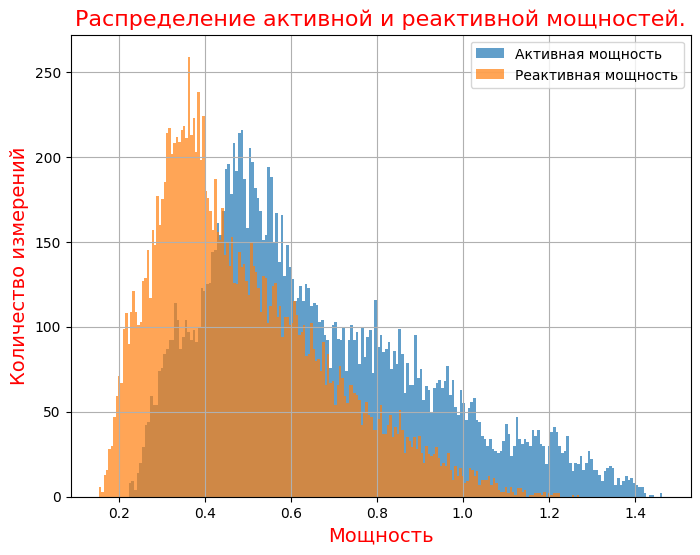

In [17]:
legend_heat = ['Активная мощность', 'Реактивная мощность']
massiv_heatinds = ['active_power', 'reactive_power']

plt.figure(figsize=(8, 6))
plt.grid(True)
plt.xlabel('Мощность', fontsize=14, color='red')
plt.ylabel('Количество измерений', fontsize=14, color='red')
plt.title(f'Распределение активной и реактивной мощностей.',
          fontsize=16, color='red')


for i in tqdm(range(2)):
    plt.hist(df['data_arc_new'][massiv_heatinds[i]], bins=200, alpha=0.7)
plt.legend(legend_heat)    

  0%|          | 0/2 [00:00<?, ?it/s]

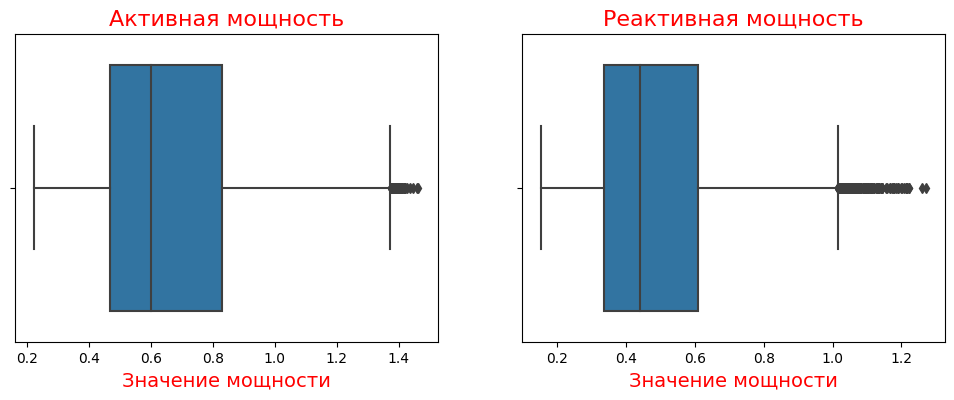

In [18]:
fig = plt.figure(figsize = (12,4))

for i in tqdm(range(2)):
    ax = fig.add_subplot(1, 2, i+1)
    sns.boxplot(df['data_arc_new'][massiv_heatinds[i]],  ax=ax)
    ax.set_title(legend_heat[i], fontsize=16, color='red')
    plt.xlabel("Значение мощности", fontsize=14, color='red')
    
plt.show()    

**Промежуточные выводы:**
1. В `'data_arc_new'` содержится информация об использовании электродов.
2. Датафрейм состоит из 14876 строк и 4 столбца.
3. Кроме них, ещё два признака имеют тип string и значения времени и даты. Отмечаем, что:
    * Изменим формат данных признаков `start_heating` и `end_heating` на datetime.
    * Для решения задачи не важно точное время начала и проведения плавки. На процесс плавления стали оказывает влияние продолжительность проведения плавки.
4. Два столбца имеют тип float64. Всё правильно.
5. По гистограммам распределения и по графикам 'ящик с усами' можно отметить, что значения активной и реактивной мощностей имеют `нормальное распределение` с небольшим смещением вправо.
6. Пропусков нет.   
7. Явных дубликатов нет.
8. Предоставленные данные охватывают период работы печи по выплавке стали в течении 4 месяцев:   
    от `2019-05-03 11:02:14` по `2019-09-06 17:26:15`.
9. Отмечаем, что измерения мощности электрода проводились при разных выплавках стали в разных количествах, от 1 до 16.    
10. Полагаю, что на результат работы печи и, в том числе, время проведения выплавки стали, влияют не активная и реактивная мощность по отдельности, а их композиция, назвем её `полной мощностью`.
11. Важно учесть, что измерения мощности проводились за разные промежутки времени. Чтобы учесть все эти факторы введем новый признак, `работа`, рассчитываемый по формуле: 
$$
W = \sqrt{A^2 + R^2} * \delta(t)
$$
где:  
    * A - Активная мощность.  
    * R - Реактивная мощность.  
    * $\delta(t)$ - Интервал времени.

Создадим дополнительную функцию для изучения датафреймов с большим количеством пропусков.

In [19]:
def view_df_null(df_temp):
    '''
    Функция для дополнительного изучения датафреймов
    с большим количеством пропусков.
    '''
    print('Размер датафрейма:', df_temp.size)
    print('Количество пропусков во всём датафрейме:', 
          df_temp.isnull().sum().sum())
    print('-' * 80)
    print('Количество строк в датафрейме:', df_temp.shape[0])
    print('Количество строк без пропущенных значений:', 
          df_temp.dropna().shape[0])
    print('-' * 80)
    print('Количество полностью пустых строк',
         sum([True for idx,row in df_temp.iterrows() if all(row.isnull())]))

#### `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём).

In [20]:
# Изучим содержимое датафрейма:

view_df(df['data_bulk_new'])

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 3129   │ │ float64     │ 15    │                                                          │
│ │ Number of columns │ 15     │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column_name        ┃ NA       ┃ NA %    ┃ mean    ┃ sd     ┃ p0     ┃ p25    ┃ p75    ┃ p100    ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━┩  │
│ │ bulk_1             │     2900 │      92 │      39 │     18 │     10 │     27 │     46 │     180 │   █▅▁    │  │
│ │ bulk_2             │     3100 │      99 │     250 │     21 │    230 │    240 │    260 │     320 │  ▅█▁▁ ▁  │  │
│ │ bulk_3             │     1800 │      59 │     110 │     75 │      6 │     58 │    150 │     450 │   █▇▃▁   │  │
│ │ bulk_4             │     2100 │      68 │     100 │     48 │     12 │     72 │    130 │     280 │  ▄██▃▁   │  │
│ │ bulk_5             │     3100 │      98 │     110 │     82 │     11 │     70 │    130 │     600 │   █▄▁    │  │
│ │ bulk_6             │     2600 │      82 │     120 │     72 │     17 │     70 │    160 │     500 │   █▆▂▁   │  │
│ │ bulk_7             │     3100 │      99 │     310 │    190 │     47 │    160 │    410 │     770 │  ▇▄█▃▂▁  │  │
│ │ bulk_8             │     3100 │     100 │      49 │    nan │     49 │     49 │     49 │      49 │      █   │  │
│ │ bulk_9             │     3100 │      99 │      76 │     22 │     63 │     66 │     70 │     150 │   █  ▁   │  │
│ │ bulk_10            │     3000 │      94 │      83 │     26 │     24 │     64 │    100 │     160 │  ▂▆██▂   │  │
│ │ bulk_11            │     3000 │      94 │      77 │     60 │      8 │     25 │    110 │     310 │   █▅▂▁   │  │
│ │ bulk_12            │      680 │      22 │     260 │    120 │     53 │    200 │    320 │    1800 │    █▂    │  │
│ │ bulk_13            │     3100 │      99 │     180 │     46 │    150 │    150 │    200 │     300 │  █▁▂ ▁▁  │  │
│ │ bulk_14            │      320 │      10 │     170 │     66 │     16 │    120 │    210 │     640 │   ▄█▂    │  │
│ │ bulk_15            │      880 │      28 │     160 │     52 │      1 │    100 │    200 │     400 │    ▇▃█   │  │
│ └────────────────────┴──────────┴─────────┴─────────┴────────┴────────┴────────┴────────┴─────────┴──────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,43.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.000,NaN,150.000,154.000
2,NaN,NaN,NaN,73.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.000,NaN,149.000,154.000
3,NaN,NaN,NaN,34.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.000,NaN,152.000,153.000


,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,
3239,NaN,NaN,NaN,NaN,NaN,114.000,NaN,NaN,NaN,NaN,NaN,158.000,NaN,270.000,88.000
3240,NaN,NaN,NaN,NaN,NaN,26.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.000,54.000
3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.000,52.000


Количество дубликатов: 80


In [21]:
# Изучим огромное количество пропусков в датафрейме:

view_df_null(df['data_bulk_new'])

Размер датафрейма: 46935
Количество пропусков во всём датафрейме: 35776
--------------------------------------------------------------------------------
Количество строк в датафрейме: 3129
Количество строк без пропущенных значений: 0
--------------------------------------------------------------------------------
Количество полностью пустых строк 0


**Промежуточные выводы:**
1. В `'data_bulk_new'` содержится информация об объёме подаваемых в плавильную печь сыпучих материалов.
2. Датафрейм состоит из 3129 строк и 15 столбцов.
3. Все столбцы имеют тип float64. Замечательно.
4. Отрицательных значений нет.
5. Отмечаем:
    * Все признаки имеют пропуски.
    * Количество пропущенных значений огромно! Около 75% от объема датафрейма.
    * Нет строк без пропущенных значений.
    * Нет полностью пустых строк.
6. В наличии 80 дубликатов!

#### `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);

In [22]:
# Изучим содержимое датафрейма:

view_df(df['data_bulk_time_new'])

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 3129   │ │ string      │ 15    │                                                          │
│ │ Number of columns │ 15     │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name              ┃ NA         ┃ NA %       ┃ words per row               ┃ total words             ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ bulk_1                   │       2900 │         92 │                        0.16 │                     500 │  │
│ │ bulk_2                   │       3100 │         99 │                        0.16 │                     500 │  │
│ │ bulk_3                   │       1800 │         59 │                        0.16 │                     500 │  │
│ │ bulk_4                   │       2100 │         68 │                        0.16 │                     500 │  │
│ │ bulk_5                   │       3100 │         98 │                        0.16 │                     500 │  │
│ │ bulk_6                   │       2600 │         82 │                        0.16 │                     500 │  │
│ │ bulk_7                   │       3100 │         99 │                        0.16 │                     500 │  │
│ │ bulk_8                   │       3100 │        100 │                        0.16 │                     500 │  │
│ │ bulk_9                   │       3100 │         99 │                        0.16 │                     500 │  │
│ │ bulk_10                  │       3000 │         94 │                        0.16 │                     500 │  │
│ │ bulk_11                  │       3000 │         94 │                        0.16 │                     500 │  │
│ │ bulk_12                  │        680 │         22 │                        0.16 │                     500 │  │
│ │ bulk_13                  │       3100 │         99 │                        0.16 │                     500 │  │
│ │ bulk_14                  │        320 │         10 │                        0.16 │                     500 │  │
│ │ bulk_15                  │        880 │         28 │                        0.16 │                     500 │  │
│ └──────────────────────────┴────────────┴────────────┴─────────────────────────────┴─────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16


,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,
3239,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:06:00,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:01:44,NaN,2019-09-06 14:58:15,2019-09-06 14:48:06
3240,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:24:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:07:29,2019-09-06 16:01:34
3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 17:26:33,2019-09-06 17:23:15


Количество дубликатов: 0


In [23]:
# Изучим огромное количество пропусков в датафрейме:

view_df_null(df['data_bulk_time_new'])

Размер датафрейма: 46935
Количество пропусков во всём датафрейме: 35776
--------------------------------------------------------------------------------
Количество строк в датафрейме: 3129
Количество строк без пропущенных значений: 0
--------------------------------------------------------------------------------
Количество полностью пустых строк 0


**Промежуточные выводы:**
1. В `'data_bulk_time_new'` содержится информация об времени подачи в плавильную печь сыпучих материалов.
2. Датафрейм состоит из 3129 строк и 15 столбцов.
3. Все столбцы имеют тип string и содержат значения даты. Для дальнейшей работы следует изменить их тип на datetime.
4. Полагаю, что интерес представляет не точное время добавки, а время от начала плавки и объём сыпучих материалов, добавленных в этот момент.
5. Отмечаем:
    * Все признаки имеют пропуски.
    * Количество пропущенных значений около 75% от объема датафрейма.
    * Нет строк без пропущенных значений.
    * Нет полностью пустых строк.
    * Пропущенные значения `полностью соответствуют` тем ячейкам, которые имеют пропуски в данных по объемам добавки сыпучих материалов.
6. Явных дубликатов нет!
7. Отмечаем, что загрузка сыпучих материалов проводилась в направлении от 'bulk_15' r 'bulk_1'. Это хорошо прослеживается по времени загрузок. 
8. Надо отметить, что легирующие добавки подавались в разном порядке и в разное временя. Например, для объекта с key = 2 видим:

    |bulk_№|time|
    |---|---|
    |bulk_4|2019-05-03 11:36:50|
    |bulk_15|2019-05-03 11:44:39|
    |bulk_14|2019-05-03 11:48:37|
    |bulk_12|2019-05-03 11:53:30|

#### `data_gas_new.csv` — данные о продувке сплава газом.

In [24]:
# Изучим содержимое датафрейма:

view_df(df['data_gas_new'])

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 3239   │ │ float64     │ 1     │                                                          │
│ │ Number of columns │ 1      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column_name        ┃ NA   ┃ NA %    ┃ mean    ┃ sd     ┃ p0         ┃ p25    ┃ p75    ┃ p100    ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━┩  │
│ │ gas_1              │    0 │       0 │      11 │    6.2 │     0.0084 │      7 │     14 │      78 │    █▃    │  │
│ └────────────────────┴──────┴─────────┴─────────┴────────┴────────────┴────────┴────────┴─────────┴──────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

,gas_1
key,
1,29.750
2,12.556
3,28.555


,gas_1
key,
3239,16.024
3240,11.863
3241,12.681


Количество дубликатов: 0


**Промежуточные выводы:**

* В `'data_gas_new'` содержится информация о продувке сплава газом. Скорее всего, объём подаваемого газа.
* Датасет состоит из 3239 строк и 1 столбца.
* Единственнный признак имеет тип float64. Всё правильно.
* Отрицательных значений нет.
* Пропусков нет.
* Явных дубликатов нет.

#### `data_temp_new.csv` — результаты измерения температуры.

In [25]:
# Изучим содержимое датафрейма:

view_df(df['data_temp_new'])

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 18092  │ │ string      │ 1     │                                                          │
│ │ Number of columns │ 2      │ │ float64     │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column_name        ┃ NA      ┃ NA %    ┃ mean    ┃ sd   ┃ p0      ┃ p25     ┃ p75     ┃ p100    ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━┩  │
│ │ temperature        │    3400 │      19 │    1600 │   20 │    1200 │    1600 │    1600 │    1700 │      █▁  │  │
│ └────────────────────┴─────────┴─────────┴─────────┴──────┴─────────┴─────────┴─────────┴─────────┴──────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                      ┃ NA     ┃ NA %      ┃ words per row              ┃ total words           ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ measurement_time                 │      0 │         0 │                          2 │                 36000 │  │
│ └──────────────────────────────────┴────────┴───────────┴────────────────────────────┴───────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

,measurement_time,temperature
key,,
1,2019-05-03 11:02:04,1571.000
1,2019-05-03 11:07:18,1604.000
1,2019-05-03 11:11:34,1618.000


,measurement_time,temperature
key,,
3241,2019-09-06 17:21:48,NaN
3241,2019-09-06 17:24:44,NaN
3241,2019-09-06 17:30:05,NaN


Количество дубликатов: 0


Отмечаем, что значения 'key' повторяются.

Попробуем скомпоновать 'key', чтобы увидеть, при каких выплавках стали измерения температуры проводились несколько раз.

In [26]:
pd.Index(df['data_temp_new'].index).value_counts()

2108    17
1513    16
1689    16
2567    15
46      14
        ..
247      2
1169     2
246      2
195      1
279      1
Name: key, Length: 3216, dtype: int64

Отмечаем, что измерения температуры проводились при разных выплавках стали в разных количествах, от 1 до 17. 

Интересно, что это распределение похоже на распределение мощности электрода:

In [27]:
pd.Index(df['data_arc_new'].index).value_counts()

2108    16
1513    15
1689    15
2567    14
46      13
        ..
2582     1
530      1
2194     1
2179     1
1988     1
Name: key, Length: 3214, dtype: int64

Признак 'temperature' должен быть целевым признаком.

Но в нём 3400 пропусков!!! Эти данные не годятся для работы. Их нужно в дальнейшем исключить.

Посмотрим объекты датафрейма с пустыми значениями измеренной температуры:

In [28]:
df['data_temp_new'][df['data_temp_new'].temperature.isnull()]

,measurement_time,temperature
key,,
2500,2019-08-10 14:13:11,NaN
2500,2019-08-10 14:18:12,NaN
2500,2019-08-10 14:25:53,NaN
2500,2019-08-10 14:29:39,NaN
2501,2019-08-10 14:49:15,NaN
...,...,...
3241,2019-09-06 16:55:01,NaN
3241,2019-09-06 17:06:38,NaN
3241,2019-09-06 17:21:48,NaN


*ВАЖНО!!!*

Все данные со значением ключа большим или равным 2500 (с середины дня 2019-08-10) не имеют значения в целевом признаке. А потому, от них нужно избавляться.

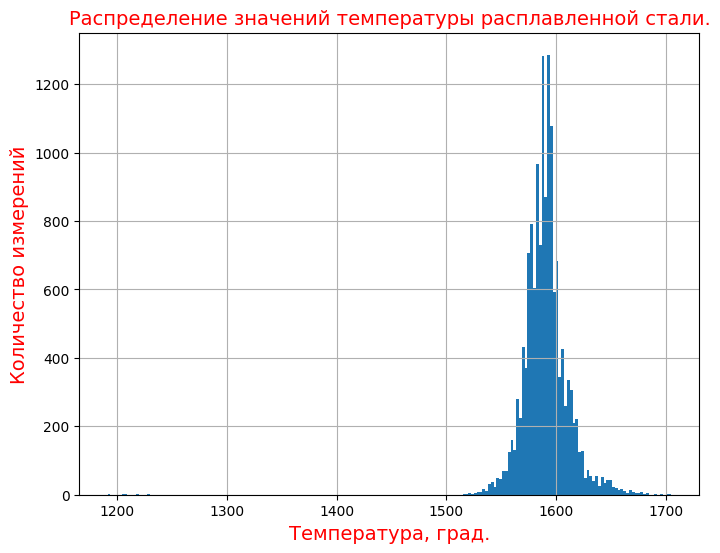

In [29]:
plt.figure(figsize=(8, 6))
plt.grid(True)
plt.xlabel('Температура, град.', fontsize=14, color='red')
plt.ylabel('Количество измерений', fontsize=14, color='red')
plt.title(f'Распределение значений температуры расплавленной стали.',
          fontsize=14, color='red')

plt.hist(df['data_temp_new'].temperature, bins=200);
   

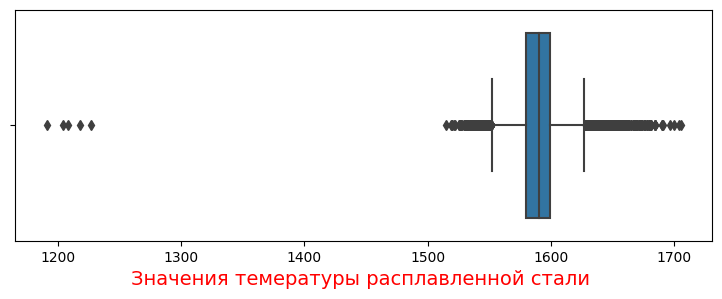

In [30]:
fig = plt.figure(figsize = (9,3))
sns.boxplot(df['data_temp_new'].temperature)
plt.xlabel("Значения температуры расплавленной стали ", fontsize=14, color='red')
plt.show;

**Промежуточные выводы:**

1. В `'data_temp_new'` содержится информация о температуре расплавленной стали в печи
2. Диапазон значений температуры от 1200 до 1700 градусов.
3. Распределение измеряемых значений температур нормальное.
4. Отмечаем значения температуры менее 1400 градусов. Они должны быть удалены.
5. Признак **`'temperature'`** должен быть **целевым признаком**.
6. Датасет состоит из 18092 строк и 2 столбца.
7. Столбец `measurement_time` имеет тип string и значения даты и времени. Следовательно, для дальнейшей работы следует изменить тип на 'datetime'.
8. Столбец `temperature` имеет тип float64. Всё правильно.
9. Отрицательных значений нет.
10. Количество пропусков равно 3400.
11. Явных дубликатов нет.
12. Отмечаем, что измерения температуры проводились при разных выплавках стали в разных количествах, от 1 до 17.    
13. Распределение измерений температуры очень хорошо соответствует распределению измерений мощности. При многократных измерений значений времени измерений мощности больше ровно на 1. Это говорит о том, что мощность измерялась за какой-то период времени (и её возможно, надо нормировать на единицу времени), а температура - в определенный момент времени.
14. Судя по количеству измерений и мощности, и температуры (до 16), они соответствуют 'bulk'! Поэтому их так много. Но количество сгруппированных значений измерений мощности и температуры примерно соответствует количеству и данных о сыпучих материалах, и количеству данных о продувке сплава газом.
15. Все данные со значением ключа большим или равным 2500 (с середины дня 2019-08-10) не имеют значения в целевом признаке. А потому, от них нужно избавляться.

#### data_wire_new.csv — данные о проволочных материалах (объём).

In [31]:
# Изучим содержимое датафрейма:

view_df(df['data_wire_new'])

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 3081   │ │ float64     │ 9     │                                                          │
│ │ Number of columns │ 9      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column_name        ┃ NA      ┃ NA %    ┃ mean    ┃ sd     ┃ p0       ┃ p25    ┃ p75   ┃ p100    ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━┩  │
│ │ wire_1             │      26 │    0.84 │     100 │     42 │      1.9 │     72 │   130 │     330 │   ▂█▅▁   │  │
│ │ wire_2             │    2000 │      65 │      51 │     39 │     0.03 │     20 │    70 │     280 │   █▄▁    │  │
│ │ wire_3             │    3000 │      98 │     190 │    100 │     0.14 │     95 │   280 │     390 │  ▂█ ▆█▁  │  │
│ │ wire_4             │    3100 │     100 │      57 │     29 │       24 │     41 │    76 │     110 │  ▅█▃▂▂▃  │  │
│ │ wire_5             │    3100 │     100 │      15 │    nan │       15 │     15 │    15 │      15 │      █   │  │
│ │ wire_6             │    3000 │      98 │      48 │     34 │    0.034 │     25 │    64 │     180 │  ▇█▄▁▁   │  │
│ │ wire_7             │    3100 │     100 │      10 │    8.6 │     0.23 │    6.8 │    12 │      33 │  ▆█▆  ▂  │  │
│ │ wire_8             │    3100 │      99 │      54 │     17 │       45 │     46 │    48 │     100 │  █ ▁  ▁  │  │
│ │ wire_9             │    3100 │      99 │      34 │     20 │      4.6 │     22 │    44 │      90 │  ▆█▅▃▃▁  │  │
│ └────────────────────┴─────────┴─────────┴─────────┴────────┴──────────┴────────┴───────┴─────────┴──────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,
1,60.060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,96.052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91.160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,
3239,143.358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3240,34.070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3241,63.118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Количество дубликатов: 403


In [32]:
# Изучим огромное количество пропусков в датафрейме:

view_df_null(df['data_wire_new'])

Размер датафрейма: 27729
Количество пропусков во всём датафрейме: 23385
--------------------------------------------------------------------------------
Количество строк в датафрейме: 3081
Количество строк без пропущенных значений: 0
--------------------------------------------------------------------------------
Количество полностью пустых строк 0


Количество пропусков огромно!    
*skimpy* даже показывает количество пропусков для некоторых признаков, превышающее количество строк. Посчитаем пустые значения заново:

In [33]:
df['data_wire_new'].isna().sum()

wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64

**Промежуточные выводы:**
1. В `'data_wire_new'` содержится информация об объёме подаваемых в плавильную печь проволочных материалов.
2. Датафрейм состоит из 3081 строк и 9 столбцов.
3. По количеству строк `'data_wire_new'` примерно соответствует `data_bulk_new`, `data_bulk_time_new`, `data_gas_new` и  даже `data_arc_new` и `data_temp_new`, разнесенных по `bulk`.
3. Все столбцы имеют тип float64. Замечательно.
4. Отрицательных значений нет.
5. Отмечаем:
    * Все признаки имеют пропуски.
    * Количество пропущенных значений огромно! Около 84% от объема датафрейма.
    * Нет строк без пропущенных значений.
    * Нет полностью пустых строк.
6. В наличии 403 дубликата!

#### `data_wire_time_new.csv` — данные о проволочных материалах (время).

In [34]:
# Изучим содержимое датафрейма:

view_df(df['data_wire_time_new'])

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 3081   │ │ string      │ 9     │                                                          │
│ │ Number of columns │ 9      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name              ┃ NA         ┃ NA %       ┃ words per row               ┃ total words             ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ wire_1                   │         26 │       0.84 │                           2 │                    6100 │  │
│ │ wire_2                   │       2000 │         65 │                           2 │                    6100 │  │
│ │ wire_3                   │       3000 │         98 │                           2 │                    6100 │  │
│ │ wire_4                   │       3100 │        100 │                           2 │                    6100 │  │
│ │ wire_5                   │       3100 │        100 │                           2 │                    6100 │  │
│ │ wire_6                   │       3000 │         98 │                           2 │                    6100 │  │
│ │ wire_7                   │       3100 │        100 │                           2 │                    6100 │  │
│ │ wire_8                   │       3100 │         99 │                           2 │                    6100 │  │
│ │ wire_9                   │       3100 │         99 │                           2 │                    6100 │  │
│ └──────────────────────────┴────────────┴────────────┴─────────────────────────────┴─────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,
1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,
3239,2019-09-06 14:36:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3240,2019-09-06 15:33:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3241,2019-09-06 17:10:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Количество дубликатов: 0


**Промежуточные выводы:**
1. В `'data_wire_time_new'` содержится информация об времени подаваемых в плавильную печь проволочных материалах.
2. Датафрейм состоит из 3081 строк и 9 столбцов.
3. Во всех столбцах значеи типа string и содержат информацию о времени. А потому тип данных должен быть изменён на datatime.
4. Явных дубликатов нет.
5. Расположение информации по времени соответствует расположению информации об объёме загруженного проволочного материала в `'data_wire_new'`.

## Предобработка данных.

### Датасет `data_arc_new.csv` — данные об электродах

#### Заменим тип данных значения с временем проведения плавки стали на `datatime`.

In [35]:
df['data_arc_new'].start_heating = \
    pd.to_datetime(df['data_arc_new'].start_heating, format='%Y-%m-%dT%H:%M:%S')
df['data_arc_new'].end_heating = \
    pd.to_datetime(df['data_arc_new'].end_heating, format='%Y-%m-%dT%H:%M:%S')
df['data_arc_new'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 1 to 3241
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   start_heating   14875 non-null  datetime64[ns]
 1   end_heating     14875 non-null  datetime64[ns]
 2   active_power    14875 non-null  float64       
 3   reactive_power  14875 non-null  float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 581.1 KB


Отмечаем, что изменения проведены без потерь.

Введём новый признак `работа`, содержащий информацию о полной мощности за время, в течение которого эта мощность измерялась:
$$
W = \sqrt{A^2 + R^2} * \delta(t)
$$
где:  
    * A - Активная мощность, `active_power`.  
    * R - Реактивная мощность, `reactive_power`.  
    * $\delta(t)$ - Интервал времени, `end_heating - start_heating` в секундах.

In [36]:
df['data_arc_new']['w_total'] = \
    (df['data_arc_new'].active_power**2 + 
     df['data_arc_new'].reactive_power**2)**0.5 * \
    (df['data_arc_new'].end_heating - \
      df['data_arc_new'].start_heating).dt.total_seconds()

# Проверим содержимое датафрейма:
display(df['data_arc_new'].shape)
display(df['data_arc_new'].head(10))

(14875, 5)

,start_heating,end_heating,active_power,reactive_power,w_total
key,,,,,
1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305,0.211,84.616
1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.766,0.477,166.929
1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580,0.430,124.276
1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518,0.380,234.631
1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867,0.644,159.830
2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381,0.220,60.313
2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.262,0.206,112.463
2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710,0.485,108.368
2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786,0.543,200.616


Проведём агрегацию данных по индексу `key` с суммированием по `a_total`.

In [37]:
df['data_arc_new'] = \
    df['data_arc_new'].pivot_table(index='key', values='w_total', aggfunc='sum')
df['data_arc_new']

,w_total
key,
1,770.282
2,481.760
3,722.838
4,683.456
5,512.170
...,...
3237,630.504
3238,286.052
3239,941.539


**Промежуточные выводы:**
1. Для значений, содержащих время проведения выплавки стали, изменили тип данных на datatime.
2. Создан новый признак `w_total` со значением полной мощности за период измерения.
3. Проведена агрегация по индексу `key` с суммированием по `w_total`.
4. Количество объектов - 3214.
5. Датасет `'data_arc_new'` подготовлен к дальнейшей работе.

### Датасет `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём).

Проверим содержимое датафрейма:

In [38]:
display(df['data_bulk_new'].shape)
display(df['data_bulk_new'].head(5))

(3129, 15)

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,43.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.000,NaN,150.000,154.000
2,NaN,NaN,NaN,73.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.000,NaN,149.000,154.000
3,NaN,NaN,NaN,34.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.000,NaN,152.000,153.000
4,NaN,NaN,NaN,81.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.000,NaN,153.000,154.000
5,NaN,NaN,NaN,78.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.000,NaN,151.000,152.000


Заменим все пропущенные значения на 0 и проверим полученный датафрейм:

In [39]:
df['data_bulk_new'] = df['data_bulk_new'].fillna(0)
df['data_bulk_new'].shape, df['data_bulk_new'].head(5)

((3129, 15),
      bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  bulk_9  \
 key                                                                           
 1     0.000   0.000   0.000  43.000   0.000   0.000   0.000   0.000   0.000   
 2     0.000   0.000   0.000  73.000   0.000   0.000   0.000   0.000   0.000   
 3     0.000   0.000   0.000  34.000   0.000   0.000   0.000   0.000   0.000   
 4     0.000   0.000   0.000  81.000   0.000   0.000   0.000   0.000   0.000   
 5     0.000   0.000   0.000  78.000   0.000   0.000   0.000   0.000   0.000   
 
      bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  
 key                                                        
 1      0.000    0.000  206.000    0.000  150.000  154.000  
 2      0.000    0.000  206.000    0.000  149.000  154.000  
 3      0.000    0.000  205.000    0.000  152.000  153.000  
 4      0.000    0.000  207.000    0.000  153.000  154.000  
 5      0.000    0.000  203.000    0.000  151.000  152.000 

**Промежуточные выводы:**
1. Пропущенные значения заменены нулем.
2. Количество объектов - 3129.
3. Датасет `'data_bulk_new'` подготовлен к дальнейшей работе.

### Датасет `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время).

Проверим содержимое датафрейма:

In [40]:
display(df['data_bulk_time_new'].shape)
display(df['data_bulk_time_new'].head(5))

(3129, 15)

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


**Промежуточные выводы:**
1. Количество объектов - 3129.
2. Информация о времени подачи в плавильный ковш сыпучих легирующих материалов не несет себе информации о потребляемой электроэнергии. Поэтому `'data_bulk_time_new'` не будет применяться в дальнейшей работе.

### Датасет `data_gas_new.csv` — данные о продувке сплава газом.

Проверим содержимое датафрейма:

In [41]:
display(df['data_gas_new'].shape)
display(df['data_gas_new'].head(5))
print('Общее количество пропущенных значений во всем DataFrame:',
    df['data_gas_new'].isnull().sum().sum())
print('Количество отрицательных значений подачи газа:',
    len(df['data_gas_new'][df['data_gas_new'].gas_1 <= 0]))

(3239, 1)

,gas_1
key,
1,29.750
2,12.556
3,28.555
4,18.841
5,5.414


Общее количество пропущенных значений во всем DataFrame: 0
Количество отрицательных значений подачи газа: 0


**Промежуточные выводы:**
1. Количество объектов - 3129.
2. Пропущенные значения отсутствуют.
3. Отрицательные значения и значения, равные нулю подачи газа, отсутствуют.
4. Датасет `'data_gas_new'` подготовлен к дальнейшей работе.

### Датасет `data_temp_new.csv` — результаты измерения температуры.

Проверим содержимое датафрейма:

In [42]:
display(df['data_temp_new'].shape)
display(df['data_temp_new'].head(10))
print('Общее количество пропущенных значений во всем DataFrame:',
    df['data_temp_new'].isnull().sum().sum())
print('Количество значений измеренной температуры, меньших 1400 градусов:',
    len(df['data_temp_new'][df['data_temp_new'].temperature <= 1400]))

(18092, 2)

,measurement_time,temperature
key,,
1,2019-05-03 11:02:04,1571.000
1,2019-05-03 11:07:18,1604.000
1,2019-05-03 11:11:34,1618.000
1,2019-05-03 11:18:04,1601.000
1,2019-05-03 11:25:59,1606.000
1,2019-05-03 11:30:38,1613.000
2,2019-05-03 11:34:04,1581.000
2,2019-05-03 11:38:40,1577.000
2,2019-05-03 11:46:09,1589.000


Общее количество пропущенных значений во всем DataFrame: 3427
Количество значений измеренной температуры, меньших 1400 градусов: 5


Изучим пустые значения:

In [43]:
df['data_temp_new'][df['data_temp_new'].temperature.isnull()]

,measurement_time,temperature
key,,
2500,2019-08-10 14:13:11,NaN
2500,2019-08-10 14:18:12,NaN
2500,2019-08-10 14:25:53,NaN
2500,2019-08-10 14:29:39,NaN
2501,2019-08-10 14:49:15,NaN
...,...,...
3241,2019-09-06 16:55:01,NaN
3241,2019-09-06 17:06:38,NaN
3241,2019-09-06 17:21:48,NaN


Отмечаем:
* пустых значений 3427.
* пустые значения расположены со значениями `key` от 2500 и выше.

Так как значения температуры нужны для создания целевого признака, избавимся от пустых значений:

In [44]:
df['data_temp_new'] = df['data_temp_new'].dropna()

# Проверим размер датасета после удаления объектов с пустыми значеними:
df['data_temp_new'].shape

(14665, 2)

**Проверим аномальные значения температуры менее 1400 градусов:**

In [45]:
df['data_temp_new'][df['data_temp_new'].temperature <= 1400]

,measurement_time,temperature
key,,
867,2019-06-06 08:03:39,1191.000
1214,2019-06-18 08:01:03,1208.000
1619,2019-07-03 02:34:41,1218.000
2052,2019-07-25 08:49:15,1227.000
2561,2019-08-12 18:49:29,1204.000


Отмечаем, что есть всего 5 значений с аномальными значениями температуры.  
Удалим их:

In [46]:
df['data_temp_new'] = df['data_temp_new'][df['data_temp_new'].temperature > 1400]

In [47]:
# Проверим количество аномальных значений:

print('Количество значений измеренной температуры, меньших 1400 градусов:',
    len(df['data_temp_new'][df['data_temp_new'].temperature <= 1400]))

Количество значений измеренной температуры, меньших 1400 градусов: 0


In [48]:
display(df['data_temp_new'].shape)
display(df['data_temp_new'].tail(10))

(14660, 2)

,measurement_time,temperature
key,,
3232,2019-09-06 08:41:35,1563.000
3233,2019-09-06 09:15:00,1597.000
3234,2019-09-06 09:41:13,1614.000
3235,2019-09-06 10:17:44,1590.000
3236,2019-09-06 10:55:40,1607.000
3237,2019-09-06 11:31:15,1569.000
3238,2019-09-06 12:16:15,1584.000
3239,2019-09-06 14:16:50,1598.000
3240,2019-09-06 15:25:21,1617.000


Отмечаем, что есть выплавки стали с единственным замером темературы.

**Удаление  выплавок стали с одним лишь значением измеренной температуры**

In [49]:
# Посмотрим наличие выплавок с однократными записями температуры:

df['data_temp_new'].pivot_table(index='key', values='measurement_time', aggfunc=[len])

,len
,measurement_time
key,
1,6
2,5
3,6
4,5
5,5
...,...
3237,1
3238,1


Видим, что записей с одним замером температуры много.

Избавимся от них:

In [50]:
df['data_temp_new'] = df['data_temp_new'][df['data_temp_new'].index.value_counts() > 1]

# Проверим получившийся датафрейм:
display(df['data_temp_new'].shape)
df['data_temp_new'].pivot_table(index='key', values='measurement_time', aggfunc=[len])

(13920, 2)

,len
,measurement_time
key,
1,6
2,5
3,6
4,5
5,5
...,...
2495,5
2496,7


Констатируем, что избавились от записей с однократными измерениями температуры.

Теперь нужно для каждой плавки стали сохранить в дополнительных признаках:
* время первого замера температуры,
* показание первого замера температуры,
* время последнего замера температуры,
* значение последнего измерения температуры.

**Создание дополнительных признаков.**

In [51]:
df['data_temp_new'] = df['data_temp_new'].groupby(by = 'key', as_index = False).agg(['first', 'last'])
df['data_temp_new']

measurement_time                      temperature         
                    first                 last       first     last
key                                                                
1     2019-05-03 11:02:04  2019-05-03 11:30:38    1571.000 1613.000
2     2019-05-03 11:34:04  2019-05-03 11:55:09    1581.000 1602.000
3     2019-05-03 12:06:44  2019-05-03 12:35:57    1596.000 1599.000
4     2019-05-03 12:39:27  2019-05-03 12:59:47    1601.000 1625.000
5     2019-05-03 13:11:03  2019-05-03 13:36:39    1576.000 1602.000
...                   ...                  ...         ...      ...
2495  2019-08-10 11:27:47  2019-08-10 11:50:47    1570.000 1591.000
2496  2019-08-10 11:56:48  2019-08-10 12:25:13    1554.000 1591.000
2497  2019-08-10 12:37:26  2019-08-10 12:53:28    1571.000 1589.000
2498  2019-08-10 12:58:11  2019-08-10 13:23:31    1591.000 1594.000
2499  2019-08-10 13:33:21  2019-08-10 13:58:58    1569.000 1603.000

[2475 rows x 4 columns]

In [52]:
df['data_temp_new'].columns = ['time_temp_init', 'time_temp_final', 'temp_init', 'temp_final']
df['data_temp_new'].head(5)

,time_temp_init,time_temp_final,temp_init,temp_final
key,,,,
1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.000,1613.000
2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.000,1602.000
3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.000,1599.000
4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.000,1625.000
5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.000,1602.000


In [53]:
# Переведем признаки, имеющие значения даты к типу datetime:

df['data_temp_new'].time_temp_init = \
    pd.to_datetime(df['data_temp_new'].time_temp_init, format='%Y-%m-%dT%H:%M:%S')
df['data_temp_new'].time_temp_final = \
    pd.to_datetime(df['data_temp_new'].time_temp_final, format='%Y-%m-%dT%H:%M:%S')

# Проверим изменение типа на datetime:
df['data_temp_new'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time_temp_init   2475 non-null   datetime64[ns]
 1   time_temp_final  2475 non-null   datetime64[ns]
 2   temp_init        2475 non-null   float64       
 3   temp_final       2475 non-null   float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 96.7 KB


Создадим новый признак `'melting_time'` - продолжительность плавки, рассчитываемый как разница между конечным и начальным замерами температуры металлургического ковша при выплавке стали.
Ненужные более признаки с времененм замера температур удалим.

In [54]:
df['data_temp_new']['melting_time'] = (df['data_temp_new'].time_temp_final - 
                                        df['data_temp_new'].time_temp_init).dt.total_seconds()
df['data_temp_new'].drop(['time_temp_init', 'time_temp_final'], axis= 1 , inplace= True )
df['data_temp_new']

,temp_init,temp_final,melting_time
key,,,
1,1571.000,1613.000,1714.000
2,1581.000,1602.000,1265.000
3,1596.000,1599.000,1753.000
4,1601.000,1625.000,1220.000
5,1576.000,1602.000,1536.000
...,...,...,...
2495,1570.000,1591.000,1380.000
2496,1554.000,1591.000,1705.000
2497,1571.000,1589.000,962.000


**Промежуточные выводы:**
1. Количество объектов датафрейма `'data_temp_new'` - 2475 .
2. Пустые значения удалены.
3. Объекты с аномальными значениями температуры менее 1400 градусов удалены.
4. Выплавки с однократными измерениями температуры исключены.
5. Созданы новые признаки:
    * `temp_init` - значение начального замера температуры, что соответствует началу плавки стали.
    * `temp_final` - итоговое значение температуры готовой стали, что соответствует окончанию выплавки стали.
    * `melting_time` - продолжительносить выплавки стали.
6. Признак `temp_final` - целевой признак для построения модели.
7. Датасет `'data_temp_new'` подготовлен к дальнейшей работе.

### Датасет `data_wire_new.csv` — данные о проволочных материалах (объём).

Проверим содержимое датафрейма:

In [55]:
display(df['data_wire_new'].shape)
display(df['data_wire_new'].head(5))

(3081, 9)

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,
1,60.060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,96.052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91.160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,89.064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,89.238,9.115,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Заменим все пропущенные значения на 0 и проверим полученный датафрейм:

In [56]:
df['data_wire_new'] = df['data_wire_new'].fillna(0)
df['data_wire_new'].shape, df['data_wire_new'].head(5)

((3081, 9),
      wire_1  wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  wire_9
 key                                                                        
 1    60.060   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000
 2    96.052   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000
 3    91.160   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000
 4    89.064   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000
 5    89.238   9.115   0.000   0.000   0.000   0.000   0.000   0.000   0.000)

**Промежуточные выводы:**
1. Пропущенные значения заменены нулем.
2. Количество объектов - 3081.
3. Датасет `'data_wire_new'` подготовлен к дальнейшей работе.

### Датасет `data_wire_time_new.csv` — данные о проволочных материалах (время).

Проверим содержимое датафрейма:

In [57]:
display(df['data_wire_time_new'].shape)
display(df['data_wire_time_new'].head(5))

(3081, 9)

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,
1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Промежуточные выводы:**
1. Количество объектов - 3081.
2. Информация о времени подачи в плавильный ковш проволочных материалов не несет себе информации о потребляемой электроэнергии. Поэтому `'data_wire_time_new'` не будет применяться в дальнейшей работе.

## Разработка моделей.

### Создание объединённого датафрейма.

Посмотрим, какие датафреймы у нас получились:

In [58]:
df_ready = ['data_arc_new', 'data_bulk_new', 'data_gas_new', 'data_temp_new', 'data_wire_new']

for df_current in df_ready:
    display(df[df_current].head(1))

,w_total
key,
1,770.282


,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,
1,0.000,0.000,0.000,43.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,206.000,0.000,150.000,154.000


,gas_1
key,
1,29.750


,temp_init,temp_final,melting_time
key,,,
1,1571.000,1613.000,1714.000


,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,
1,60.060,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [59]:
# размеры подготовленных датафреймов:

for df_current in df_ready:
    print(df_current, ' - ', df[df_current].shape)

data_arc_new  -  (3214, 1)
data_bulk_new  -  (3129, 15)
data_gas_new  -  (3239, 1)
data_temp_new  -  (2475, 3)
data_wire_new  -  (3081, 9)


**Создадим результирующий объединённый датафрейм `data`.**

Сначала к базовому `'data_arc_new'` (3214 объектов) добавим датафрейм бОльшего размера `'data_gas_new'` (3239 объекта).
Делать это нужно с ключом how = 'left'. Так мы сохраним все значения из левой таблицы (`'data_arc_new'`), а из правой (`'data_gas_new'`) возьмём только те значения, которые есть в левой.

In [60]:
data = df['data_arc_new'].merge(df['data_gas_new'], how = 'left', on = 'key')
data

,w_total,gas_1
key,,
1,770.282,29.750
2,481.760,12.556
3,722.838,28.555
4,683.456,18.841
5,512.170,5.414
...,...,...
3237,630.504,5.544
3238,286.052,6.746
3239,941.539,16.024


Далее последовательно добавим все оставшиеся датафреймы по правилу взаимного пересечения:

In [61]:
data = data.merge(df['data_temp_new'], on = 'key')
data = data.merge(df['data_bulk_new'], on = 'key')
data = data.merge(df['data_wire_new'], on = 'key')

# Исключим объекты с пустыми значениями:
data = data.dropna()

# Сбросим индекс:
data.reset_index(drop= True , inplace= True )

# Изучим содержимое датафрейма:
view_df(data)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 2329   │ │ float64     │ 29    │                                                          │
│ │ Number of columns │ 29     │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column_name       ┃ NA   ┃ NA %    ┃ mean      ┃ sd     ┃ p0        ┃ p25    ┃ p75    ┃ p100    ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━┩  │
│ │ w_total           │    0 │       0 │       670 │    320 │        33 │    460 │    840 │    4500 │    █▃    │  │
│ │ gas_1             │    0 │       0 │        11 │    6.4 │    0.0084 │    7.3 │     14 │      78 │    █▃    │  │
│ │ temp_init         │    0 │       0 │      1600 │     24 │      1500 │   1600 │   1600 │    1700 │  ▁▃█▆▃▁  │  │
│ │ temp_final        │    0 │       0 │      1600 │     11 │      1500 │   1600 │   1600 │    1700 │   ▁█▃▁   │  │
│ │ melting_time      │    0 │       0 │      2300 │   1400 │       270 │   1600 │   2800 │   24000 │    █     │  │
│ │ bulk_1            │    0 │       0 │       3.4 │     12 │         0 │      0 │      0 │     180 │    █     │  │
│ │ bulk_2            │    0 │       0 │       1.4 │     19 │         0 │      0 │      0 │     320 │    █     │  │
│ │ bulk_3            │    0 │       0 │        47 │     75 │         0 │      0 │     80 │     450 │   █▂▁    │  │
│ │ bulk_4            │    0 │       0 │        37 │     59 │         0 │      0 │     77 │     280 │   █▁▁▁   │  │
│ │ bulk_5            │    0 │       0 │       2.6 │     22 │         0 │      0 │      0 │     600 │    █     │  │
│ │ bulk_6            │    0 │       0 │        22 │     56 │         0 │      0 │      0 │     500 │    █▁    │  │
│ │ bulk_7            │    0 │       0 │         2 │     31 │         0 │      0 │      0 │     770 │    █     │  │
│ │ bulk_8            │    0 │       0 │     0.021 │      1 │         0 │      0 │      0 │      49 │    █     │  │
│ │ bulk_9            │    0 │       0 │      0.44 │    6.2 │         0 │      0 │      0 │     150 │    █     │  │
│ │ bulk_10           │    0 │       0 │       5.1 │     21 │         0 │      0 │      0 │     160 │    █     │  │
│ │ bulk_11           │    0 │       0 │       4.2 │     23 │         0 │      0 │      0 │     310 │    █     │  │
│ │ bulk_12           │    0 │       0 │       210 │    160 │         0 │    100 │    280 │    1800 │    █▂    │  │
│ │ bulk_13           │    0 │       0 │       1.1 │     14 │         0 │      0 │      0 │     300 │    █     │  │
│ │ bulk_14           │    0 │       0 │       150 │     81 │         0 │    100 │    200 │     640 │   ▄█▃    │  │
│ │ bulk_15           │    0 │       0 │       120 │     85 │         0 │      0 │    200 │     400 │   ▇▆▄█   │  │
│ │ wire_1            │    0 │       0 │       100 │     44 │         0 │     73 │    130 │     330 │   ▂█▆▁   │  │
│ │ wire_2            │    0 │       0 │        18 │     34 │         0 │      0 │     23 │     280 │    █▁    │  │
│ │ wire_3            │    0 │       0 │       3.2 │    

,w_total,gas_1,temp_init,temp_final,melting_time,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,770.282,29.750,1571.000,1613.000,1714.000,0.000,0.000,0.000,43.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,206.000,0.000,150.000,154.000,60.060,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,481.760,12.556,1581.000,1602.000,1265.000,0.000,0.000,0.000,73.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,206.000,0.000,149.000,154.000,96.052,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,722.838,28.555,1596.000,1599.000,1753.000,0.000,0.000,0.000,34.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,205.000,0.000,152.000,153.000,91.160,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


,w_total,gas_1,temp_init,temp_final,melting_time,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
2326,823.021,6.272,1571.000,1589.000,962.000,0.000,0.000,0.000,85.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,230.000,0.000,124.000,226.000,94.087,9.048,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2327,581.811,14.954,1591.000,1594.000,1520.000,0.000,0.000,90.000,0.000,0.000,0.000,0.000,0.000,0.000,101.000,0.000,206.000,0.000,129.000,207.000,118.111,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2328,532.386,11.336,1569.000,1603.000,1537.000,0.000,0.000,47.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,233.000,0.000,126.000,227.000,110.161,50.005,0.000,0.000,0.000,0.000,0.000,0.000,0.000


Количество дубликатов: 0


Отмечаем, что признак 'wire_5' полностью состоит из нулевых значений. Поэтому удалим его.

In [62]:
data.drop('wire_5', axis= 1 , inplace= True )
data.shape

(2329, 28)

**Промежуточные выводы:**
1. В объединенном датафрейме:
    * Количество объектов - 2329.
    * Количество признаков - 28.
    * Пропущенных значений нет.
    * Дубликатов нет.
    * Все признаки имеют тип 'float64'.
2. Датафрейм `'data'` готов к дальнейшей работе.

### Изучим наши данные на мультиколлинеарность признаков.

Посмотрим взаимную корреляцию признаков датасета:

  0%|          | 0/1 [00:00<?, ?it/s]

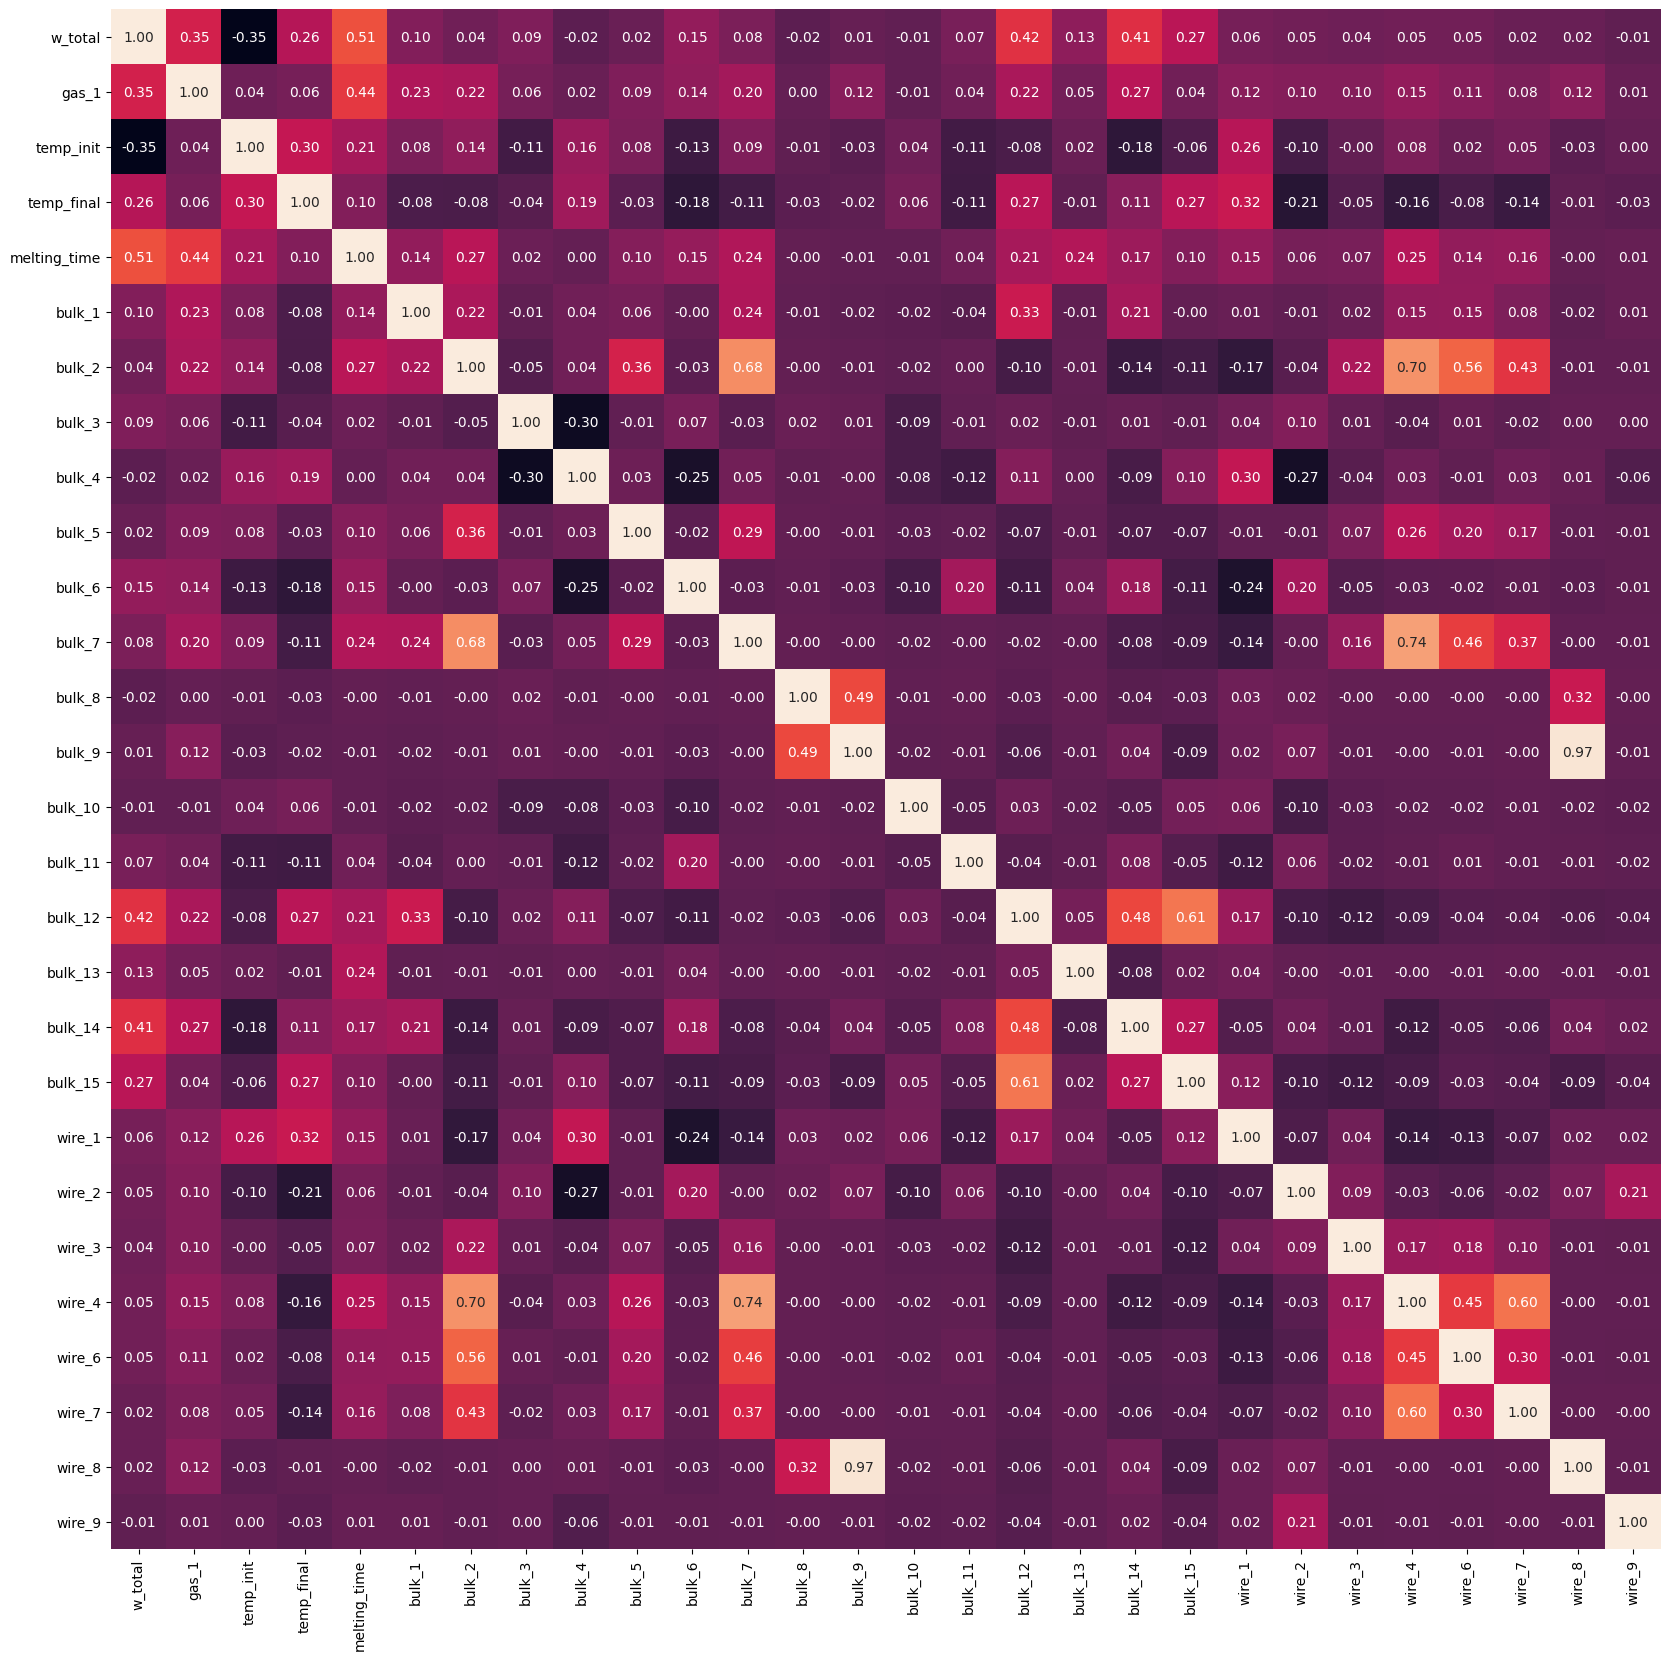

In [63]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for i in tqdm(range(1)):

    plt.figure(figsize=(20,20))
    sns.heatmap(data.corr(), annot=True, annot_kws={"size":10}, fmt = '.2f', cbar=False)
    plt.show()

Отмечаем очень высокое значение `0.97`коэффициента Пирсона между признаками `'wire_8'` и `'bulk_9'`. Физический смысл такой взаимосвязи непонятен, так как неизвестно что такое `'wire_8'` и `'bulk_9'`.
Поэтому один из признаков необходимо удалить. Пусть это будет `'wire_8'`.

In [64]:
data.drop('wire_8', axis= 1 , inplace= True )
data.shape

(2329, 27)

**Промежуточный вывод**

В связи с высокой взаимной зависимостью между `'wire_8'` и `'bulk_9'` (corr = 0.97) удалён признак `'wire_8'`.

### Разделение на выборки train и test.

In [65]:
# Выделим целевой признак:
features = data.drop('temp_final', axis=1)
target = data['temp_final']

# Разделим данные на обучающую и тестовую выборки:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=TEST_SIZE_FIX, random_state=RANDOM_STATE_FIX)

print('Проверим данные после разбиения на выборки, нет ли потерь:\n')

if( data.shape[0] == (features_train.shape[0] + features_test.shape[0])):
    print('После разделения датафрейма в обучающей выборке потерь нет.')
else:
    print('ВНИМАНИЕ! Есть потеря данных в обучающей выборке.\n' \
          'Сумма количества объектов в обучающей выборке НЕ равно ' \
          'количеству объектов исходного датафрейма.')
    print(data.shape[0], features_train.shape[0] + features_test.shape[0])
    
if( data.shape[0] == (target_train.shape[0] + target_test.shape[0])):
    print('После разделения датасета в тестовой выборке потерь нет.')
else:
    print('ВНИМАНИЕ! Есть потеря данных в тестовой выборке.\n' \
          'Сумма количества объектов в тестовой выборке НЕ равно ' \
          'количеству объектов исходного датасета.')
    print(data.shape[0], target_train.shape[0] + target_test.shape[0])

Проверим данные после разбиения на выборки, нет ли потерь:

После разделения датафрейма в обучающей выборке потерь нет.
После разделения датасета в тестовой выборке потерь нет.


### Масштабирование численных признаков обучающей выборки.

Отмечаем, что у наших численных признаков сильно отличающийся масштаб. Есть значения даже в сотни тысяч.   
Чтобы при последующей обработке такие высокие цифры не воспринимались, как более важные признаки, проведем их к одному масштабу. 

In [66]:
columns_name = features_train.columns

# Преобразуем данные с помощью StandardScaler.

# Создадим объект структуры StandardScaler:
scaler = StandardScaler()

# Настроим объект на обучающих данных:
scaler.fit(features_train[columns_name]) 

# Преобразуем функцией transform():
features_train[columns_name] = scaler.transform(features_train[columns_name])  
features_test[columns_name] = scaler.transform(features_test[columns_name]) 

# Проверим полный список признаков:
print('Датафрейм:', '"features_train"', 'имеет размер: ', features_train.shape)
display(features_train.sample(5))

print('Датафрейм:', '"features_test"', 'имеет размер: ', features_test.shape)   
display(features_test.sample(5))

Датафрейм: "features_train" имеет размер:  (1746, 26)


,w_total,gas_1,temp_init,melting_time,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_9
560,-0.094,-0.525,0.417,-0.638,-0.297,-0.072,0.448,-0.648,-0.108,-0.398,-0.063,-0.024,-0.064,-0.231,-0.188,-0.703,-0.072,0.009,-0.235,-1.005,-0.517,-0.109,-0.064,-0.115,-0.035,-0.091
1183,-0.314,-0.298,-0.232,0.027,-0.297,-0.072,-0.627,1.262,-0.108,-0.398,-0.063,-0.024,-0.064,-0.231,-0.188,0.120,-0.072,-0.633,-0.223,0.172,-0.517,-0.109,-0.064,-0.115,-0.035,-0.091
1641,1.420,-0.173,-0.448,1.030,3.477,-0.072,2.187,-0.648,1.360,1.795,-0.063,-0.024,-0.064,-0.231,-0.188,1.297,-0.072,1.230,0.989,-0.935,1.396,-0.109,-0.064,-0.115,-0.035,-0.091
2043,0.105,0.198,0.027,-0.201,-0.297,-0.072,0.581,-0.648,-0.108,-0.398,-0.063,-0.024,-0.064,-0.231,-0.188,-0.049,-0.072,0.034,-0.175,1.608,0.394,-0.109,-0.064,-0.115,-0.035,-0.091
2013,-1.219,-0.590,0.071,-0.380,-0.297,-0.072,-0.627,-0.648,-0.108,0.109,-0.063,-0.024,-0.064,-0.231,-0.188,-0.670,-0.072,-0.281,-0.781,-0.428,-0.517,-0.109,-0.064,-0.115,-0.035,-0.091


Датафрейм: "features_test" имеет размер:  (583, 26)


,w_total,gas_1,temp_init,melting_time,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_9
2014,0.442,1.023,-0.578,1.050,-0.297,-0.072,-0.627,-0.648,-0.108,1.360,-0.063,-0.024,-0.064,-0.231,-0.188,1.976,-0.072,1.570,-0.199,0.152,-0.517,-0.109,-0.064,-0.115,-0.035,-0.091
72,-0.467,-1.374,-0.967,-0.556,-0.297,-0.072,-0.627,-0.648,-0.108,1.523,-0.063,-0.024,-0.064,-0.231,-0.188,0.284,-0.072,-0.205,0.966,-1.281,-0.149,-0.109,-0.064,-0.115,-0.035,-0.091
1752,-0.219,0.392,1.108,0.366,-0.297,-0.072,0.130,-0.648,-0.108,-0.398,-0.063,-0.024,-0.064,-0.231,-0.188,-0.043,-0.072,-0.683,-0.211,0.101,-0.517,-0.109,-0.064,-0.115,-0.035,-0.091
1586,0.508,-0.605,-2.135,-0.543,-0.297,-0.072,-0.627,-0.648,-0.108,-0.398,-0.063,-0.024,-0.064,-0.231,-0.188,1.238,-0.072,0.437,0.550,-0.083,-0.517,-0.109,-0.064,-0.115,-0.035,-0.091
1475,-1.281,0.588,0.590,-0.186,-0.297,-0.072,-0.627,-0.648,-0.108,-0.398,-0.063,-0.024,-0.064,-0.231,-0.188,-1.383,-0.072,-0.180,-1.447,-0.565,2.762,-0.109,-0.064,-0.115,-0.035,-0.091


**Промежуточные выводы:**
1. Создали `train` и `test` выборки.
2. Провели масштабирование численных признаков обучающей выборки.


### Создание вспомогательных фенкций.

#### Функции для обучения модели, расчета предсказаний и фиксации времени работы.

In [67]:
def fit_model_time(model, X, y):
    '''
    Функция обучает модель и фиксирует время на проведение обучения.
    '''
    begin = time.time()
    model.fit(X, y)
    return model, time.time() - begin

#### Датафрейм для сохранения результатов работы.

In [68]:
df_results = pd.DataFrame(columns=[
    'model', 'MAE', 'fitting time, с', 'parameters'])


def model_metrics(df, RMSE, fit_time, param, model):
    '''
    Функция добавит в результы в df: 
    RMSE, время обучения и параметры модели
    '''
    if model not in list(df['model']):  
        df.loc[len(df.index )] = [model, RMSE, 
                                  fit_time, param]
    return df

**Для оценки качества моделей применяем метрику MAE.**

### Линейные модели.

#### `Линейная регрессия`.

In [69]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    
    #1: Создание схемы cross-validation
    folds = KFold(n_splits=5, random_state=RANDOM_STATE_FIX, shuffle=True)
       
#    scores = cross_val_score(lm, features_train, target_train, 
#                             scoring='neg_mean_absolute_error', cv=folds)
#    print(scores)
    
    #2: Определяем набор гиперпараметров как список обучающих признаков 
    num_features = len(features_train.columns)
    hyper_params = [{'n_features_to_select': list(range(0, num_features))}]
    
    #3: Построение grid search
    #3.1 создаём model
    lm = LinearRegression()
    lm.fit(features_train, target_train)
    rfe = RFE(lm)             

    #3.2 вызов GridSearchCV()
    LR_model = GridSearchCV(estimator = rfe, 
                            param_grid = hyper_params, 
                            scoring= 'neg_mean_absolute_error', 
                            cv = folds, 
                            verbose = 1,
                            return_train_score=True)      

    model, fit_time = fit_model_time(LR_model, 
                                     features_train, target_train) 
    
    model_metrics(df_results, abs(model.best_score_), 
                  fit_time, model.best_params_, 
                  'LinearRegression+GridSearchCV')
display(df_results)    

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 26 candidates, totalling 130 fits


,model,MAE,"fitting time, с",parameters
0,LinearRegression+GridSearchCV,6.465,4.465,{'n_features_to_select': 12}


#### Модель `дерево решений` 'Decision Tree' с подбором глубины дерева.

In [70]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    model = DecisionTreeRegressor(random_state=RANDOM_STATE_FIX)
    parameters = {'max_depth':range(1, 10)}
    DTR_model = GridSearchCV(model, parameters, cv=5, 
        scoring='neg_mean_absolute_error', verbose=1)
    model, fit_time = fit_model_time(
        DTR_model, features_train, target_train) 
    
model_metrics(df_results, abs(model.best_score_), fit_time, 
              model.best_params_, 
              'DecisionTreeRegressor+GridSearchCV')

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


,model,MAE,"fitting time, с",parameters
0,LinearRegression+GridSearchCV,6.465,4.465,{'n_features_to_select': 12}
1,DecisionTreeRegressor+GridSearchCV,7.130,0.371,{'max_depth': 5}


**Промежуточные выводы:**
    
Построены две линейные модели:
* `Линейная регрессия` с механизмом кросс-валидацией.
* Модель `дерево решений` 'Decision Tree' с подбором глубины дерева.

### Ансамблевые методы регрессии.

#### Модель `Cлучайного леса` c подбором гиперпараметров GridSearchCV.

In [71]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    model = RandomForestRegressor(random_state=RANDOM_STATE_FIX)

    parameters = {'max_depth': range(10, 15), 
                  'n_estimators': range(220, 226)}
    grid_model = GridSearchCV(model, parameters, cv=5, 
                              scoring='neg_mean_absolute_error', verbose=1)
    RFR_model, fit_time = fit_model_time(grid_model, features_train, target_train)

    model_metrics(df_results, abs(RFR_model.best_score_),
                  fit_time, RFR_model.best_params_,
                  'RandomForestRegressor+GridSearchCV')
    
display(df_results)

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 30 candidates, totalling 150 fits


,model,MAE,"fitting time, с",parameters
0,LinearRegression+GridSearchCV,6.465,4.465,{'n_features_to_select': 12}
1,DecisionTreeRegressor+GridSearchCV,7.130,0.371,{'max_depth': 5}
2,RandomForestRegressor+GridSearchCV,6.388,222.151,"{'max_depth': 12, 'n_estimators': 223}"


#### Модель `GradientBoostingRegressor`  c подбором гиперпараметров GridSearchCV.

In [72]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    parameters = {'max_depth' : range(1, 8),
                  'n_estimators': range(10, 15, 1), 
                  'learning_rate': [0.2, 0.3, 0.4] }
    model = GradientBoostingRegressor(random_state=RANDOM_STATE_FIX)
    grid_model = GridSearchCV(model, parameters, cv=5, 
                              scoring='neg_mean_absolute_error', verbose=1)
    GBR_model, fit_time = fit_model_time(grid_model, features_train, target_train)
    
    model_metrics(df_results, abs(GBR_model.best_score_), 
                  fit_time, GBR_model.best_params_, 
                  'GradientBoostingRegressor+GridSearchCV')

display(df_results)    

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 105 candidates, totalling 525 fits


,model,MAE,"fitting time, с",parameters
0,LinearRegression+GridSearchCV,6.465,4.465,{'n_features_to_select': 12}
1,DecisionTreeRegressor+GridSearchCV,7.130,0.371,{'max_depth': 5}
2,RandomForestRegressor+GridSearchCV,6.388,222.151,"{'max_depth': 12, 'n_estimators': 223}"
3,GradientBoostingRegressor+GridSearchCV,6.427,24.272,"{'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 13}"


**Промежуточные выводы:**

Построены две ансамблевые модели:
* Модель `Cлучайного леса` c подбором гиперпараметров GridSearchCV.
* Модель `GradientBoostingRegressor`  c подбором гиперпараметров GridSearchCV.

### Итеративные модели.

#### Модель градиентного бустинга `LightGBM` c подбором гиперпараметров GridSearchCV.

In [73]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    parameters = {'max_depth' :  range(3, 6),
                  'n_estimators': range(330, 351, 5), 
                  'learning_rate': [0.01, 0.02, 0.02]
                 }
    model = LGBMRegressor(random_state=RANDOM_STATE_FIX, objective='regression')
    grid_model = GridSearchCV(model, parameters, cv=5, n_jobs=-1,
                              scoring='neg_mean_absolute_error', verbose=1)
    LGBM_model, fit_time = fit_model_time(grid_model, features_train, target_train)
    
    model_metrics(df_results, abs(LGBM_model.best_score_), 
                  fit_time, LGBM_model.best_params_, 
                  'LGBMRegressor+GridSearchCV')
    
display(df_results) 

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 45 candidates, totalling 225 fits


,model,MAE,"fitting time, с",parameters
0,LinearRegression+GridSearchCV,6.465,4.465,{'n_features_to_select': 12}
1,DecisionTreeRegressor+GridSearchCV,7.130,0.371,{'max_depth': 5}
2,RandomForestRegressor+GridSearchCV,6.388,222.151,"{'max_depth': 12, 'n_estimators': 223}"
3,GradientBoostingRegressor+GridSearchCV,6.427,24.272,"{'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 13}"
4,LGBMRegressor+GridSearchCV,6.283,12.078,"{'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 340}"


#### Модель градиентного бустинга `CatBoost` c подбором гиперпараметров GridSearchCV.

In [74]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    parameters = {'max_depth' : range(3, 8, 1),
                  'iterations': range(530, 541, 5),
                  'verbose': [0]}
    model = CatBoostRegressor(random_state=RANDOM_STATE_FIX)
    grid_model = GridSearchCV(model, parameters, cv=5, n_jobs=-1,
                              scoring='neg_mean_absolute_error')
    CatBR_model, fit_time = fit_model_time(grid_model, features_train, target_train)
    
    model_metrics(df_results, abs(CatBR_model.best_score_), 
                  fit_time, CatBR_model.best_params_, 
                  'CatBoostRegressor+GridSearchCV')
    
display(df_results) 

  0%|          | 0/1 [00:00<?, ?it/s]

,model,MAE,"fitting time, с",parameters
0,LinearRegression+GridSearchCV,6.465,4.465,{'n_features_to_select': 12}
1,DecisionTreeRegressor+GridSearchCV,7.130,0.371,{'max_depth': 5}
2,RandomForestRegressor+GridSearchCV,6.388,222.151,"{'max_depth': 12, 'n_estimators': 223}"
3,GradientBoostingRegressor+GridSearchCV,6.427,24.272,"{'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 13}"
4,LGBMRegressor+GridSearchCV,6.283,12.078,"{'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 340}"
5,CatBoostRegressor+GridSearchCV,6.399,61.881,"{'iterations': 535, 'max_depth': 5, 'verbose': 0}"


#### Модель градиентного бустинга `XGBoost` с использованием GridSearch.

In [75]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    parameters = {'max_depth' : range(5, 15),
                  'n_estimators': range(15, 26)
                 }
    model = xgb.XGBRFRegressor(random_state=RANDOM_STATE_FIX)
    grid_model = GridSearchCV(model, parameters, cv=5, n_jobs=-1,
                              scoring='neg_mean_absolute_error')
    XGBR_model, fit_time = fit_model_time(grid_model, features_train, target_train)
    
    model_metrics(df_results, abs(XGBR_model.best_score_), 
                  fit_time, XGBR_model.best_params_, 
                  'XGBRFRegressor+GridSearchCV111')
    
display(df_results) 

  0%|          | 0/1 [00:00<?, ?it/s]

,model,MAE,"fitting time, с",parameters
0,LinearRegression+GridSearchCV,6.465,4.465,{'n_features_to_select': 12}
1,DecisionTreeRegressor+GridSearchCV,7.130,0.371,{'max_depth': 5}
2,RandomForestRegressor+GridSearchCV,6.388,222.151,"{'max_depth': 12, 'n_estimators': 223}"
3,GradientBoostingRegressor+GridSearchCV,6.427,24.272,"{'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 13}"
4,LGBMRegressor+GridSearchCV,6.283,12.078,"{'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 340}"
5,CatBoostRegressor+GridSearchCV,6.399,61.881,"{'iterations': 535, 'max_depth': 5, 'verbose': 0}"
6,XGBRFRegressor+GridSearchCV111,6.482,15.549,"{'max_depth': 10, 'n_estimators': 21}"


**Промежуточные выводы:**

Построены три итеративные модели:
* Модель градиентного бустинга `LightGBM` c подбором гиперпараметров GridSearchCV.
* Модель градиентного бустинга `CatBoost` c подбором гиперпараметров GridSearchCV.
* Модель градиентного бустинга `XGBoost` с использованием GridSearch.

### Создание и обучение моделей на Pipeline.

In [76]:
%%time

C_range = loguniform(1e-3, 1).rvs(10000, random_state=RANDOM_STATE_FIX).round(3)
estimators_range = uniform(1,500).rvs(10000, random_state=RANDOM_STATE_FIX).astype(int)
max_depth_range = uniform(1,30).rvs(10000, random_state=RANDOM_STATE_FIX).astype(int)

pipeline = make_imblearn_pipeline(RandomForestRegressor())
pipeline.steps[-1] = ('clf', pipeline.steps[-1][1])

param_grid = [
    {   'linearregression': [LinearRegression()],
        'clf__C': C_range,
        'clf_pipeline__standardscaler': 
             [MinMaxScaler(), StandardScaler()],
    },
    
    {
        'clf': [DecisionTreeRegressor(random_state=RANDOM_STATE_FIX)],
        'clf__max_depth': max_depth_range
    },

    {
        'clf': [RandomForestRegressor(random_state=RANDOM_STATE_FIX)],
        'clf__n_estimators': estimators_range,
        'clf__max_depth': max_depth_range,
    },
    
    {
        'clf': [GradientBoostingRegressor(random_state=RANDOM_STATE_FIX, learning_rate=0.3)],
        'clf__n_estimators': estimators_range,
        'clf__max_depth': max_depth_range,
    },
    
    {
        'clf': [LGBMRegressor(random_state=RANDOM_STATE_FIX, learning_rate=0.3)],
        'clf__n_estimators': estimators_range,
        'clf__max_depth': max_depth_range,
    },
      
    {
        'clf': [CatBoostRegressor(random_state=RANDOM_STATE_FIX, verbose=0)],
        'clf__n_estimators': estimators_range,
        'clf__max_depth': max_depth_range,
    },
    
    {
        'clf': [xgb.XGBRFRegressor(random_state=RANDOM_STATE_FIX, eta=1)],
        'clf__n_estimators': estimators_range,
        'clf__max_depth': max_depth_range,
    }
]

Pipe_model = RandomizedSearchCV(pipeline,  
                                param_grid, 
                                n_iter=30,
                                cv=3, 
                                scoring = 'neg_mean_absolute_error',
                                random_state=RANDOM_STATE_FIX,
                               )

# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    Pipe_model.fit(features_train, target_train)
    
print('best_params :', Pipe_model.best_params_)
print('-' * 50)
print('best_score :', round(abs(Pipe_model.best_score_), 3))    

  0%|          | 0/1 [00:00<?, ?it/s]

best_params : {'clf__n_estimators': 476, 'clf__max_depth': 5, 'clf': <catboost.core.CatBoostRegressor object at 0x000001D012745AF0>}
--------------------------------------------------
best_score : 6.436
CPU times: total: 7min 54s
Wall time: 2min 23s


In [77]:
# Посмотрим тройку лучших моделей, рассчитанных Pipeline:

pd.reset_option('all')
pd.options.display.max_colwidth = None
cv_results = pd.DataFrame(Pipe_model.cv_results_)
cv_results = cv_results.sort_values("mean_test_score", ascending=False)
cv_results = cv_results.reset_index(drop=True)
cv_results[['rank_test_score', 'params', 'mean_test_score', 
            'mean_fit_time']].head(3)

,rank_test_score,params,mean_test_score,mean_fit_time
0,1,"{'clf__n_estimators': 476, 'clf__max_depth': 5, 'clf': <catboost.core.CatBoostRegressor object at 0x000001D012745AF0>}",-6.435854,0.958653
1,2,"{'clf__n_estimators': 497, 'clf__max_depth': 9, 'clf': RandomForestRegressor(random_state=300623)}",-6.465588,2.328982
2,3,"{'clf__n_estimators': 419, 'clf__max_depth': 16, 'clf': RandomForestRegressor(random_state=300623)}",-6.466534,2.948686


In [78]:
# Сформируем имя лучшей pipeline модели:

text = str(cv_results.params[0]['clf'])
try:
    found = re.search('(.+?)Regressor', text).group(1) + \
            'Regressor+Pipeline'
except AttributeError:
    found = ''

# Сформируем список параметров лучшей pipeline модели:
param_pipe = '{' + \
             'clf__n_estimators : ' + \
             str(cv_results.params[0]['clf__n_estimators']) + \
             ', clf__max_depth : ' + \
             str(cv_results.params[0]['clf__max_depth']) + \
            '}'


# Добавим модель, рассчитанную pipeline в наш список моделей:
df_results.loc[len(df_results.index )] = \
    [found, 
     abs(cv_results.mean_test_score[0]),
     cv_results.mean_fit_time[0],
     param_pipe
    ]
pd.set_option('display.float_format', '{:.3f}'.format) 

**Промежуточные выводы:**
    
Построен конвейер `pipeline` для построения 7 моделей:
* `LinearRegression` - линейная модель.
* `DecisionTreeRegressor` - линейная модель.
* `RandomForestRegressor` - ансамблевая модель.
* `GradientBoostingRegressor` - ансамблевая модель.
* `LGBMRegressor` - итеративная модель градиентного бустинга.
* `CatBoostRegressor` - итеративная модель градиентного бустинга.
* `XGBRFRegressor` - итеративная модель градиентного бустинга.

В качестве лучшей определена `CatBoostRegressor`.

### Определим наилучшую модель.

In [79]:
# Отсортируем модели по значению MAE:
df_final = df_results.sort_values(by = ['MAE'])
df_final = df_final.reset_index(drop=True)
df_final

,model,MAE,"fitting time, с",parameters
0,LGBMRegressor+GridSearchCV,6.283,12.078,"{'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 340}"
1,RandomForestRegressor+GridSearchCV,6.388,222.151,"{'max_depth': 12, 'n_estimators': 223}"
2,CatBoostRegressor+GridSearchCV,6.399,61.881,"{'iterations': 535, 'max_depth': 5, 'verbose': 0}"
3,GradientBoostingRegressor+GridSearchCV,6.427,24.272,"{'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 13}"
4,<catboost.core.CatBoostRegressor+Pipeline,6.436,0.959,"{clf__n_estimators : 476, clf__max_depth : 5}"
5,LinearRegression+GridSearchCV,6.465,4.465,{'n_features_to_select': 12}
6,XGBRFRegressor+GridSearchCV111,6.482,15.549,"{'max_depth': 10, 'n_estimators': 21}"
7,DecisionTreeRegressor+GridSearchCV,7.130,0.371,{'max_depth': 5}


Наименьшее значение MAE, равное 6.283  имеет модель :
LGBMRegressor+GridSearchCV


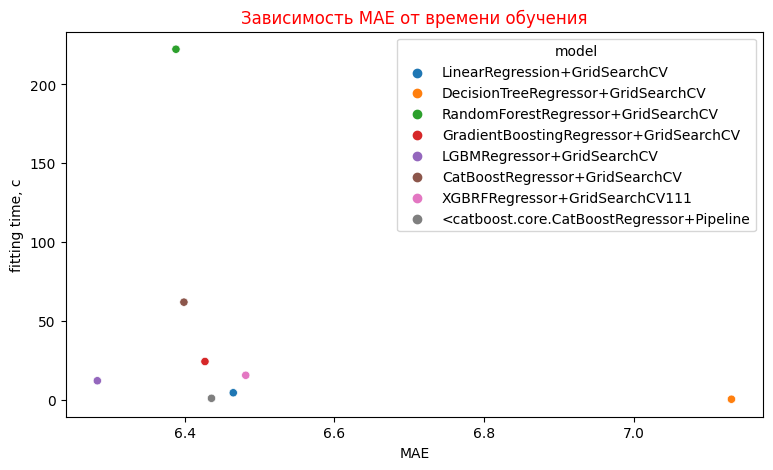

In [80]:
print('Наименьшее значение MAE, равное', round(df_final.MAE[0], 3), \
      ' имеет модель :')
print(df_final.model[0])

# Представим все отработанные модели на графике.

plt.figure(figsize = (9,5))
sns.scatterplot(data = df_results, x ='MAE', y='fitting time, с', hue="model")
plt.title('Зависимость MAE от времени обучения',
          fontsize=12, color='red');
plt.show()

**Промежуточные выводы:**

In [81]:
print('Лучшей моделью является', df_final.model[0], 
      'имеющая минимальные MAE и время обучения.')

Лучшей моделью является LGBMRegressor+GridSearchCV имеющая минимальные MAE и время обучения.


### Проверка лучшей модели на тестовой выборке.

In [82]:
predictions = LGBM_model.predict(features_test) 
MAE_test_model = mean_absolute_error(predictions, target_test)

print('Значение MAE на тестовой выборке по лучшей модели:', 
      round(MAE_test_model, 2), end='')
if MAE_test_model < 6.8:
    print(', что ЛУЧШЕ требуемого значения 6.8.')
else:
    print(', что НЕ удовлетворяет требованию получить MAE меньше 6.8!')

Значение MAE на тестовой выборке по лучшей модели: 6.71, что ЛУЧШЕ требуемого значения 6.8.


Для интереса, проверим и Pipeline модель

In [83]:
predictions = Pipe_model.predict(features_test) 
MAE_pipe_model = mean_absolute_error(predictions, target_test)

print('Значение MAE на тестовой выборке по лучшей модели:', 
      round(MAE_pipe_model, 2), end='')
if MAE_pipe_model < 6.8:
    print(', что ЛУЧШЕ требуемого значения 6.8.')
else:
    print(', что НЕ удовлетворяет требованию получить MAE меньше 6.8!')

Значение MAE на тестовой выборке по лучшей модели: 6.59, что ЛУЧШЕ требуемого значения 6.8.


**Промежуточные выводы:**
    
Значение MAE для лучшей модели на тестовой выборке соответствует требованиям задания на проект.

### Изучение важности признаков.

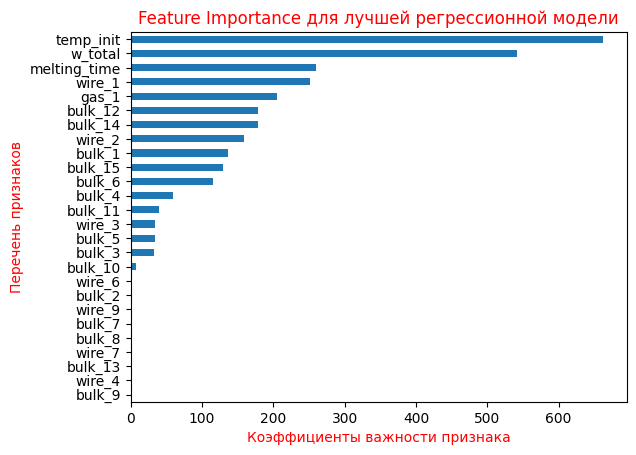

In [84]:
# Построим таблицу важности обучающих признаков:
pd.Series(index=features_train.columns, 
          data=LGBM_model.best_estimator_.feature_importances_) \
    .sort_values().plot(kind='barh')
_ = plt.title("Feature Importance для лучшей регрессионной модели",
              fontsize=12, color='red')
plt.xlabel("Коэффициенты важности признака", fontsize=10, color='red')
plt.ylabel("Перечень признаков", fontsize=10, color='red');

**Промежуточные выводы:**

In [85]:
# Создадим кортеж из значений feature_importances_
# и названий признаков:
feature_tuple_all = \
    tuple(zip(LGBM_model.best_estimator_.feature_importances_,
              features_train.columns))

# Создадим список полезных признаков с НЕнулевыми feature_importances_
feature_list_important = \
    [i[1] for i in feature_tuple_all if i[0] > 0.1]
print('Спиков ВАЖНЫХ для модели признаков:')
print(feature_list_important) 

feature_list_important_values = \
    [i[0] for i in feature_tuple_all if i[0] > 0.1]

# Создадим список полезных признаков с нулевыми feature_importances_
feature_list_unimportant = \
    [i[1] for i in feature_tuple_all if i[0] <= 0.1]
print('\nСписок НЕВАЖНЫХ для модели признаков:')
print(feature_list_unimportant) 
print('Эти признаки не нужны для построения прогноза температуры стали.')

Спиков ВАЖНЫХ для модели признаков:
['w_total', 'gas_1', 'temp_init', 'melting_time', 'bulk_1', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'wire_3', 'wire_6']

Список НЕВАЖНЫХ для модели признаков:
['bulk_2', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_13', 'wire_4', 'wire_7', 'wire_9']
Эти признаки не нужны для построения прогноза температуры стали.


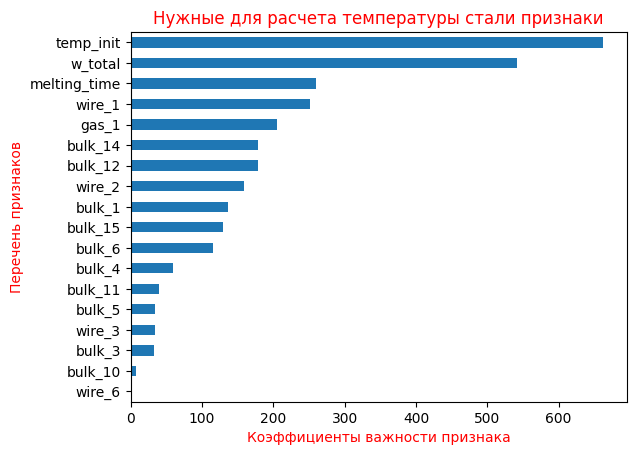

In [86]:
# Построим таблицу важности обучающих признаков:
pd.Series(index=feature_list_important, 
          data=feature_list_important_values) \
    .sort_values().plot(kind='barh')
_ = plt.title("Нужные для расчета температуры стали признаки",
              fontsize=12, color='red')
plt.xlabel("Коэффициенты важности признака", fontsize=10, color='red')
plt.ylabel("Перечень признаков", fontsize=10, color='red');

**Промежуточные выводы:**
    
Изучены и определены важные и несущественные признаки для расчёта температуры выплавки стали.    

### Построение лучшей модели ТОЛЬКО по важным признакам.

Создадим датафреймы только с важными признаками.

In [87]:
features_train_small = features_train[feature_list_important]
features_test_small = features_test[feature_list_important]
display(features_train_small.head(3))
display(features_test_small.head(3))

,w_total,gas_1,temp_init,melting_time,bulk_1,bulk_3,bulk_4,bulk_5,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_6
398,0.505,-0.965,-1.270,-0.692,-0.297,-0.627,0.907,-0.108,-0.398,-0.231,-0.188,-1.383,-1.929,-1.447,1.360,-0.517,-0.109,-0.115
1102,0.121,-0.760,0.200,-0.126,-0.297,-0.627,0.805,-0.108,-0.398,-0.231,-0.188,0.290,-1.929,-1.447,2.092,-0.150,-0.109,-0.115
179,-0.619,-0.438,-0.059,-0.832,-0.297,-0.627,1.634,-0.108,-0.398,-0.231,-0.188,-1.383,0.751,-1.447,0.382,-0.063,-0.109,-0.115


,w_total,gas_1,temp_init,melting_time,bulk_1,bulk_3,bulk_4,bulk_5,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_6
254,0.113,0.174,-0.059,-0.442,-0.297,0.170,-0.648,-0.108,-0.398,-0.231,-0.188,-0.703,1.293,-1.447,0.151,0.848,-0.109,-0.115
1865,-0.645,0.420,0.244,-0.059,-0.297,-0.627,-0.648,-0.108,1.722,-0.231,0.442,-1.383,-0.054,-1.447,-1.119,4.120,-0.109,-0.115
1466,1.536,0.532,-0.967,1.093,-0.297,0.196,-0.648,-0.108,-0.398,-0.231,-0.188,1.624,0.588,1.025,0.382,0.091,-0.109,-0.115


Обучим лучшую модель только по важным признакам.

In [88]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    parameters = {'max_depth' : range(1, 10),
                  'n_estimators': range(10, 21), 
                  'learning_rate': [0.2, 0.3, 0.4] }
    model = LGBMRegressor(random_state=RANDOM_STATE_FIX, objective='regression')
    grid_model = GridSearchCV(model, parameters, cv=5, n_jobs=-1,
                              scoring='neg_mean_absolute_error', verbose=1)
    LGBM_small_model, fit_time = fit_model_time(
        grid_model, features_train_small, target_train)
    
    model_metrics(df_results, abs(LGBM_small_model.best_score_), 
                  fit_time, LGBM_small_model.best_params_, 
                  'LGBMRegressor_small+GridSearchCV')
    
display(df_results) 

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 297 candidates, totalling 1485 fits


,model,MAE,"fitting time, с",parameters
0,LinearRegression+GridSearchCV,6.465,4.465,{'n_features_to_select': 12}
1,DecisionTreeRegressor+GridSearchCV,7.130,0.371,{'max_depth': 5}
2,RandomForestRegressor+GridSearchCV,6.388,222.151,"{'max_depth': 12, 'n_estimators': 223}"
3,GradientBoostingRegressor+GridSearchCV,6.427,24.272,"{'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 13}"
4,LGBMRegressor+GridSearchCV,6.283,12.078,"{'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 340}"
5,CatBoostRegressor+GridSearchCV,6.399,61.881,"{'iterations': 535, 'max_depth': 5, 'verbose': 0}"
6,XGBRFRegressor+GridSearchCV111,6.482,15.549,"{'max_depth': 10, 'n_estimators': 21}"
7,<catboost.core.CatBoostRegressor+Pipeline,6.436,0.959,"{clf__n_estimators : 476, clf__max_depth : 5}"
8,LGBMRegressor_small+GridSearchCV,6.323,6.420,"{'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 15}"


**Промежуточные выводы:**  

Обучена лучшая модель только по важным признакам.  
* Значение MAE = 6.323, что чуть хуже, чем на модели с полным количеством призкаков c MAE = 6.283.
* Время обучения модели только с важными признаками сократилось в 2.5 раза, с 13.9 до 5.5 секунд.

### Проверка на константной модели.

In [89]:
model_dum = DummyRegressor(strategy="median")
model_dum.fit(features_train, target_train)
predict_dum = model_dum.predict(features_test) 

MAE_dummy_model = mean_absolute_error(predict_dum, target_test)  

print('Проведена проверка модели на адекватность.\n')
print('Для константной модели MAE =', round(MAE_dummy_model, 2), end='')
if (MAE_dummy_model > MAE_test_model):
    print(', что больше, чем на тестовой выборке: ', 
          round(MAE_test_model, 2), '.', sep='')
    print('Модель - адекватная.')
else:
    print(', что меньше, чем на тестовой выборке: ',
         round(MAE_test_model, 2), '.', sep='')
    print('Модель НЕ прошла проверку на адекватность!')

Проведена проверка модели на адекватность.

Для константной модели MAE = 8.85, что больше, чем на тестовой выборке: 6.71.
Модель - адекватная.


**Промежуточные выводы:**

Проведена успешная проверка адекватности модели на константной выборке.

## Отчёт.

**По результатам исследования можно отметить следующие факты и сделать следующие выводы:**

1.Для проведения исследования получены данные с контрольными измерениями по ходу выплавки стали на металлургическом комбинате:
    * мощность электродов с фиксированным временем её измерения,
    * объёме и времени подачи сыпучих легирующих материалов,
    * объёме продуваемого инертного газа,
    * результаты измерения температуры и фиксацией времени измерения,
    * объеме и времени подачи проволочных материалов.

2.Данные подготовлены для дальнейшего анализа:
* названия столбцов приведены к стилю `snake_case`,
* признаки, содержащие информацию о дате и времени приведены к типу datetime.
* удалены аномальные значения,
* проведена проверка и заполнение пропусков,
* выполнена проверка на наличие дубликатов,
* изучены распределения активной и реактивной мощностей,
* установлено, что предоставленные данные охватывают период работы печи по выплавке стали в течении 4 месяцев: от '2019-05-03 11:02:14' по '2019-09-06 17:26:15'.
* отмечено, что в данных о продувке инертных газов отсутствуют нулевые и отрицательные значения.

3.Разработка технологических данных выплавки стали:
* отмечено, что измерения мощности электрода проводились при разных выплавках стали в одном ковше в разных количествах, от 1 до 16.
* Создан новый признак `работа`, рассчитываемый по формуле: 
$$
W = \sqrt{A^2 + R^2} * \delta(t)
$$
где:  
    - A - Активная мощность.  
    - R - Реактивная мощность.  
    - $\delta(t)$ - Интервал времени.
* Данные по объёмам добавляемых материалов имеют 15 признаков с разными легирующими добавками, выгружаемыми в металлугический ковш в зафиксированное время. Значение времени не влияет на температуру расплавленной стали. Важным является сумма всех легирующих добавок оп отдельности, добавленных по ходу плавки в один ковш.
* Исключены выплавки с однократными измерениями температуры.
* Созданы новые признаки:
    * показание первого замера температуры, что соответствует началу выплавки стали,
    * значение последнего измерения температуры, что соответствует окончанию выплавки стали..
    * продолжительность плавки, рассчитываемая как разница между конечным и начальным замерами температуры металлургического ковша при выплавке стали.
* Определен целевой признак для построения модели - значение последнего измерения температуры.
* Данные по объёмам проволочных материалов имеют 9 признаков. Время загрузки в металлугический ковш зафиксировано. Значение времени не влияет на температуру расплавленной стали. Важным является сумма всех проволочных добавок оп отдельности, добавленных по ходу плавки в один ковш.

4.Создадим результирующий объединённый датафрейм.

5.Проведено исследование `мультиколлинеарности` признаков. Установлено  очень высокое значение 0.97 коэффициента Пирсона между признаками `'wire_8'` и `'bulk_9'`. В связи с высокой взаимной зависимостью между `'wire_8'` и `'bulk_9'` (corr = 0.97) удалён признак `'wire_8'`.

6.Датасет разделен на `train` и `test` выборки.

7.Выполнено масштабирование численных признаков обучающей выборки.

8.Согласно заданию на проект, для оценки качества моделей выбрана метрика MAE.

9.Созданы и обучены модели:
* линейные модели:
    * `Линейная регрессия` с механизмом кросс-валидацией.
    * Модель `дерево решений` Decision Tree с подбором глубины дерева.
* ансамблевые модели:
    * Модель `Cлучайного леса` c подбором гиперпараметров GridSearchCV.
    * Модель `GradientBoostingRegressor`  c подбором гиперпараметров GridSearchCV.
* итеративные модели:
    * Модель градиентного бустинга `LightGBM` c подбором гиперпараметров GridSearchCV.
    * Модель градиентного бустинга `CatBoost` c подбором гиперпараметров GridSearchCV.
    * Модель градиентного бустинга `XGBoost` с использованием GridSearch.
    
10.Построен конвейер `pipeline` для создания и оценки 7 моделей:  

    - 'LinearRegression' - линейная модель.
    - 'DecisionTreeRegressor' - линейная модель.
    - 'RandomForestRegressor' - ансамблевая модель.
    - 'GradientBoostingRegressor' - ансамблевая модель.
    - 'LGBMRegressor' - итеративная модель градиентного бустинга.
    - 'CatBoostRegressor' - итеративная модель градиентного бустинга.
    - 'XGBRFRegressor' - итеративная модель градиентного бустинга.
В качестве лучшей в piprline определена модель 'CatBoostRegressor'.    

11.Лучшей моделью является `LGBMRegressor+GridSearchCV` имеющая минимальные MAE = 6.283 и время обучения модели 11 секунд.

12.Проведена проверка лучшей модели на тестовой выборке. Значение MAE на тестовой выборке по лучшей модели: 6.71, что лучше требуемого значения 6.8,
и соответствует требованиям задания на проект.

13.Изучены и определены важные и несущественные признаки для расчёта температуры выплавки стали.

14.Обучена лучшая модель только по важным признакам.
* Значение MAE = 6.32, что чуть хуже, чем на модели с полным количеством призкаков c MAE = 6.28.
* Время обучения модели только с важными признаками сократилось в 2.5 раза, с 13.9 до 5.5 секунд.

15.Проведена успешная проверка адекватности модели на константной выборке.

16.Наиболее важным для оценки температуры стали во время её выплавки является признак `начальная температура`. Чем меньше остынет первичная сталь до начала её легирования, тем меньше будут затраты электроэнергии. 

17.Вторым по важности является признак полная мощность работы электродов за весь цикл выплавки стали. Он прямо влияет на потребление электроэнергии.

18.Судя по тому, что интервалы времени между загрузками добавок неравномерны, металлурги добавляют их, ориентируясь на некие свои показатели. Для экономии электроэнергии можно рекомендовать автоматическую загрузку нужных добавок в зависимости от качественных ориентиров металлугов.

19.Ответы на вопросы руководителя проекта.

19.1. Какие пункты плана были выполнены, а какие нет (поясните, почему)?  

    - Выполнены и перевыполнены все пункты плана. Построены 7 моделей с GridSearchCV в ручном режиме и эти же 7 моделей в конвейере pipeline.
    
19.2. Какие трудности возникли и как вы их преодолели?

    - Были вопросы по техническом вопросам поставленной задачи. Непонятно было, что делать с датафреймами, содержащими информацию по времени загрузки легирующих сыпучих и проволочных добавок. Трудно было принять, что нужно отбросить такую информацию. 
    
19.3. Какие ключевые шаги в решении задачи выделили?

    - 1) Вникнуть в технические вопросы задания.
    - 2) Подготовить данные.
    - 3) Построить модели.
    - 4) Определить лучшую модель и протестировать её.
    - 5) Выделить важные признаки.

19.4. Какая ваши итоговая модель и какое у неё качество?

Лучшей моделью является `LGBMRegressor+GridSearchCV` имеющая минимальные MAE = 6.283 и время обучения модели 11 секунд со следующими значениями гиперараметров:

    - 'learning_rate': 0.02, 
    - 'max_depth': 4, 
    - 'n_estimators': 340,
    - 'random_state' : 300623.
    - Список важных для модели признаков: 'w_total', 'gas_1', 'temp_init', 'melting_time', 'bulk_1', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'wire_3', 'wire_6'

19.5. Что рекомендуете для улучшения модели, решения.

    - Для шести из семи (за исключением модели 'дерево решений') значение MAE укладывается в узком диапазоне значений от 6.28 до 6.48. Это говорит о том, что развитие моделей и подбор других гиперпараметров (пробовал) не дают существенного улучшения матрики MAE. Следовательно, надо работать с данными.
    - Добавить фамилию сталевара. Исследовать, есть ли профессионалы с минимальными затратами электроэнергии. Изучить их опыт и передать другим.
    - Отмечать температуру загружаемых добавок и пропускаемого в печь газа.
    - Увеличить выборку данных, по возможности добавить результаты с других подобных предприятий.
    - Построить график вывода температуры от начальной доя рабочей температуры выплавки легированной стали, отслеживать и выяснять причину резких отклонений в обе стороны. Лучше всего - в автоматическом режиме, как указывал выше. Причины потерь электроэнергии - в скачках её потребления.
    - Важно равномерно расставить датчики измерения температуры внутри плавильного ковша. При столь ввысоких температурах вертикальный и горизонтальные градиенты температуры существенны. Важно понимать, что мы получаем на обработку. 

20.Металлургам для контроля расхода электроэнергии в ходе выплавки стали   можно рекомендовать использовать модель ‘LGBMRegressor’.

[Вернутся к общему списку проектов курса Data_Science Яндекс-практикума](../README.md)